<a href="https://colab.research.google.com/github/hosngholami/RecommenderSystem/blob/main/RecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install opendatasets
!pip install geopy
!pip install folium
!pip install -U pymoo
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=2f81ef4c4cad2eb204c3b477d78fd33aba9c15ed4a74d7fef74f1f627633b216
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [9]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", 1000)
pd.set_option('display.max_rows', 1000)
np.set_printoptions(threshold=np.inf)

In [10]:
import random
import matplotlib.pyplot as plt
locations = pd.read_csv('/content/drive/MyDrive/Shiraz/locations.csv')
locations["Id"] = [i for i in range(0, len(locations))]
locations["Stars"] = 0
locations["Price"] = 0
# locations["Price"] = [random.randint(10, 200) for i in range(len(locations))]

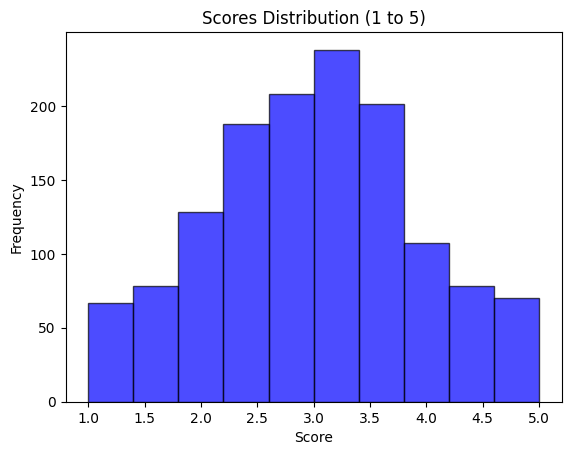

In [11]:
mean_score = 3  # میانگین امتیاز (در وسط بازه 1 تا 5)
std_dev = 1     # انحراف معیار امتیاز

# تعداد آیتم‌ها
num_items = len(locations)

# تولید امتیازات خام با توزیع نرمال
raw_scores = np.random.normal(mean_score, std_dev, num_items)
scores = np.clip(raw_scores, 1, 5)
data = pd.DataFrame({'Item': [f'Item_{i+1}' for i in range(num_items)], 'Score': scores})

# مرتب‌سازی بر اساس امتیاز و اختصاص رتبه
data = data.sort_values(by='Score', ascending=False).reset_index(drop=True)
data['Rank'] = data.index + 1

# رسم هیستوگرام امتیازات
plt.hist(scores, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Scores Distribution (1 to 5)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

locations["Stars"] = scores

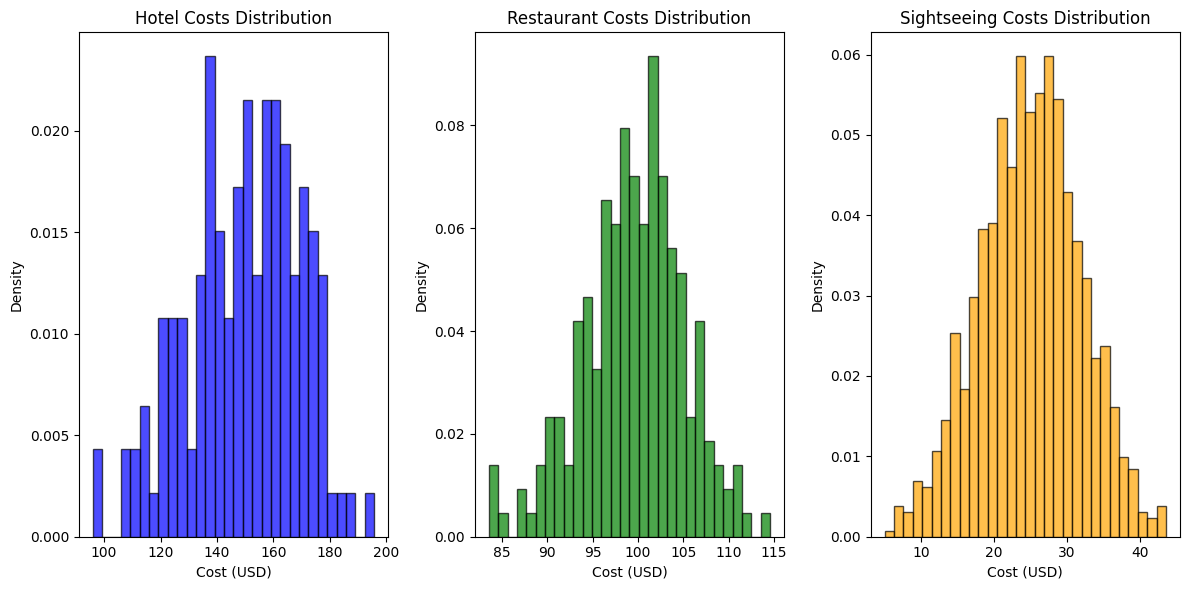

In [12]:
import numpy as np


# تعداد مکان‌ها
num_hotels = len(locations[locations["type"] == "hotel"])         # تعداد هتل‌ها
num_restaurants = len(locations[locations["type"] == "restaurant"])    # تعداد رستوران‌ها
num_sightseeing = len(locations[~locations["type"].isin(['hotel', 'restaurant'])])    # تعداد مکان‌های دیدنی

# پارامترهای توزیع نرمال برای هزینه‌های واحد
# هزینه هتل
mean_hotel = 150  # میانگین هزینه هر هتل (دلار)
std_hotel = 20    # انحراف معیار هزینه هر هتل

# هزینه رستوران
mean_restaurant = 100  # میانگین هزینه هر رستوران (دلار)
std_restaurant = 5    # انحراف معیار هزینه هر رستوران

# هزینه مکان‌های دیدنی
mean_sightseeing = 25  # میانگین هزینه هر مکان دیدنی (دلار)
std_sightseeing = 7     # انحراف معیار هزینه هر مکان دیدنی

# تولید هزینه‌ها برای هر بخش
hotel_costs = np.random.normal(mean_hotel, std_hotel, num_hotels)
restaurant_costs = np.random.normal(mean_restaurant, std_restaurant, num_restaurants)
sightseeing_costs = np.random.normal(mean_sightseeing, std_sightseeing, num_sightseeing)

# رسم نمودار توزیع نرمال برای هر بخش
plt.figure(figsize=(12, 6))

# نمودار هتل‌ها
plt.subplot(1, 3, 1)
plt.hist(hotel_costs, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title('Hotel Costs Distribution')
plt.xlabel('Cost (USD)')
plt.ylabel('Density')

# نمودار رستوران‌ها
plt.subplot(1, 3, 2)
plt.hist(restaurant_costs, bins=30, color='green', alpha=0.7, edgecolor='black', density=True)
plt.title('Restaurant Costs Distribution')
plt.xlabel('Cost (USD)')
plt.ylabel('Density')

# نمودار مکان‌های دیدنی
plt.subplot(1, 3, 3)
plt.hist(sightseeing_costs, bins=30, color='orange', alpha=0.7, edgecolor='black', density=True)
plt.title('Sightseeing Costs Distribution')
plt.xlabel('Cost (USD)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()



indexHotel = locations[locations["type"] == "hotel"].index

for i in indexHotel:
   locations.loc[i, "Price"] = int(hotel_costs[i])

indexRestaurant = locations[locations["type"] == "restaurant"].index

c = 0
for i in indexRestaurant:
   locations.loc[i, "Price"] = restaurant_costs[c]
   c += 1


c = 0
indexSightseeing = locations[~locations["type"].isin(['hotel', 'restaurant'])].index
for i in indexSightseeing:
   locations.loc[i, "Price"] = sightseeing_costs[c]
   c +=1



In [ ]:
set(locations["type"])

{'caffe',
 'historic',
 'hotel',
 'museum',
 'park',
 'placeofworship',
 'restaurant',
 'swimmingpool'}

In [13]:
def getLocation():
   location = locations[locations["type"] != "hotel"].sample(n=1)
   return location["Id"].values[0]

In [14]:
class GeneticAlgorithmConfig():
  totalLocationSize = 1
  hotelSize = 1
  numberLocationSize = len(locations[locations["type"] != "hotel"])
  totalRouteSize = 10
  timePlaceMappingSize = 2
  n_var = ((numberLocationSize * timePlaceMappingSize) +
         (hotelSize * timePlaceMappingSize) +
         (totalLocationSize))
  maxDistance = -1
  maxCost = -1
  maxRate = -1
  pareto_generations = []
  number_genrations = 0
  preference = {}


In [15]:
def getSliceRoute(route):
  length = route[0] * GeneticAlgorithmConfig.timePlaceMappingSize
  startHead = GeneticAlgorithmConfig.hotelSize
  endHead = (GeneticAlgorithmConfig.hotelSize * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize

  startTail = length + endHead
  endTail  = length + endHead + GeneticAlgorithmConfig.timePlaceMappingSize
  interior = []
  if(route[0] != 0):
      interior = route[endHead:startTail]

  return (route[startHead:endHead], interior, route[startTail:endTail])

In [16]:
userPreference = {"Historical": 0.01,
                  "Recreational": 0.01,
                  "Natural": 0.01,
                  "Adventure": 0.01,
                  "Religious": 0.01,
                  "Resort": 0.01,
                  "Artistic": 0.01,
                  "Photography": 0.01,
                  "Cultural": 5}

In [17]:
locations["tag"] = [[] for _ in range(len(locations))]

In [18]:
preference = userPreference.keys()
prefernce = list(preference)
prefernce = [key for key in preference if key != 'Resort']




index = locations[locations["type"] != "hotel"].index


for i in index:
  countRandom = np.random.randint(0, len(prefernce))
  if(countRandom == 0):
    countRandom = 1
  for _ in range(countRandom):
    rand = np.random.randint(0, len(prefernce))
    if(rand == 0):
      tag = prefernce[2]
      if(tag not in locations.iloc[i]["tag"]):
        locations.iloc[i]["tag"].append(tag)
    else:
      for _ in range(0, rand):
        tag = prefernce[rand]
        if(tag not in locations.iloc[i]["tag"]):
          locations.iloc[i]["tag"].append(tag)

# locations

In [19]:
index = locations[locations["type"] == "hotel"].index
for i in index:
  if('Resort' not in locations.iloc[i]["tag"]):
    locations.iloc[i]["tag"].append('Resort')
locations

,Unnamed: 0,name,name:en,tag,type,Latitude,Longitude,Id,Stars,Price
0,0,هتل هما,Homa Hotel,[Resort],hotel,52.542056,29.627516,0,2.418643,133.000000
1,1,ITTIC,NaN,[Resort],hotel,52.572353,29.611979,1,2.945696,125.000000
2,2,هتل جهانگردی,NaN,[Resort],hotel,52.572018,29.611642,2,1.996830,128.000000
3,3,هتل آریو برزن,Aryo Barzan Hotel,[Resort],hotel,52.541213,29.622286,3,2.143382,160.000000
4,4,هتل کریمخان,Karim Khan Hotel,[Resort],hotel,52.541173,29.622023,4,2.786381,159.000000
...,...,...,...,...,...,...,...,...,...,...
1358,1358,کافه قرار,Gharar Café,"[Photography, Natural, Recreational, Artistic]",caffe,52.479574,29.571434,1358,4.056131,20.488476
1359,1359,کافه سه کنج,Seh Konj Cafe,"[Cultural, Artistic, Photography]",caffe,52.537592,29.616573,1359,2.760281,16.288283
1360,1360,کافه پدربزرگ,Pedarbozorg Cafe,"[Cultural, Religious, Natural, Photography]",caffe,52.506764,29.581426,1360,1.268297,27.502925
1361,1361,کافهtohi,NaN,"[Natural, Religious]",caffe,52.569189,29.591688,1361,1.153422,18.091537


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      497 |      5 |             - |             -
pareto front 0
[[0.   4.92 0.23]
 [0.   3.71 0.85]
 [0.   4.72 0.37]
 [0.   3.94 0.8 ]
 [0.   4.62 0.61]
 [0.14 3.22 0.24]
 [0.2  2.85 0.24]
 [0.29 2.29 0.32]
 [0.29 2.01 0.39]
 [0.42 2.43 0.26]
 [0.7  3.35 0.01]
 [0.74 2.41 0.25]
 [0.84 2.18 0.28]
 [1.25 2.14 0.26]
 [1.64 2.83 0.19]]
--------------------------
pareto front 1
[[0.   4.47 0.26]
 [0.   4.44 0.41]
 [0.   4.42 0.59]
 [0.2  2.37 0.21]
 [0.48 2.19 0.21]
 [0.47 1.9  0.28]
 [0.6  1.19 0.24]
 [0.97 2.06 0.22]
 [0.05 2.4  0.16]
 [0.91 2.45 0.13]
 [1.03 2.07 0.17]
 [0.99 1.66 0.19]
 [1.3  2.16 0.01]
 [1.55 2.06 0.02]
 [1.53 2.12 0.02]]
--------------------------
pareto front 2
[[0.   3.76 0.54]
 [0.   3.99 0.52]
 [0.   4.42 0.38]
 [0.   4.22 0.45]
 [0.24 2.16 0.18]
 [0.44 2.16 0.17]
 [0.32 1.8  0.23]
 [0.33 1.52 0.28]
 [0.93 1.97 0.19]
 [0.11 2.41 0.01]
 [0.35 2.32 0.02]
 [0.66 2.29 0.1 ]
 [0.77 2.34 0.01]
 [1.01 

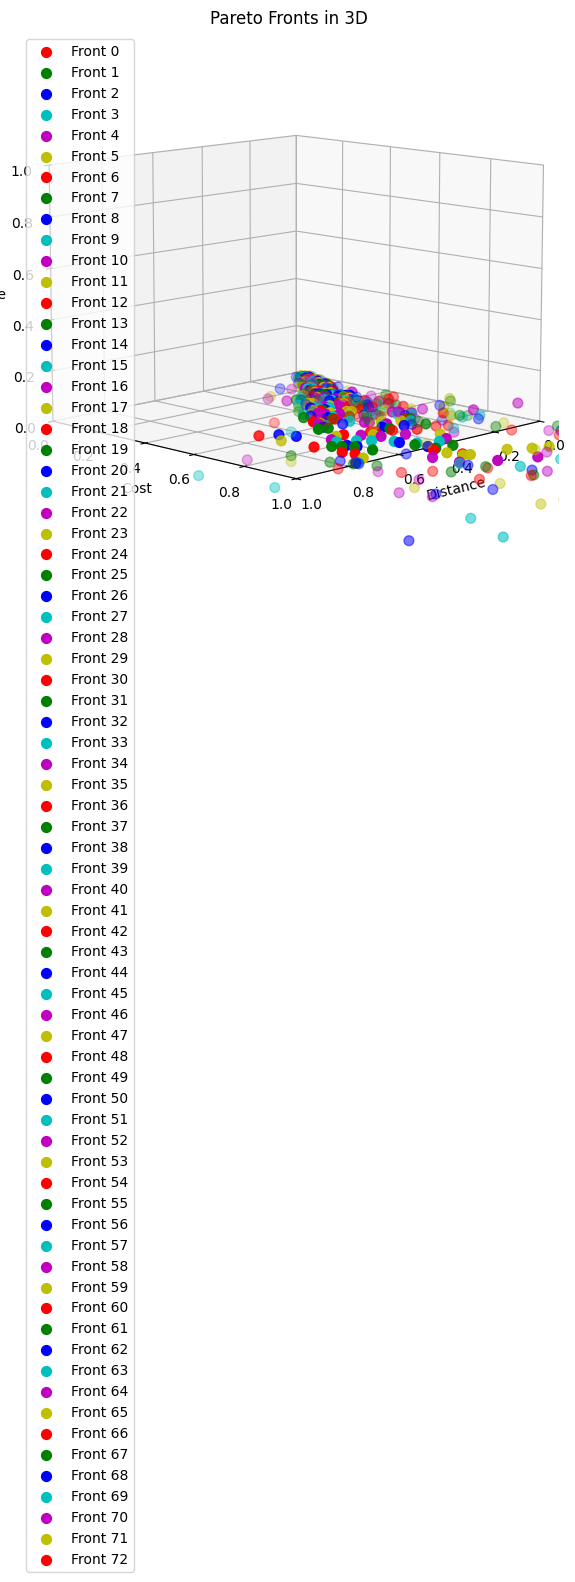

     2 |      997 |      9 |  0.0029069767 |         ideal
pareto front 0
[[0.   4.92 0.23]
 [0.   3.71 0.85]
 [0.   3.94 0.8 ]
 [0.   4.72 0.37]
 [0.   4.62 0.61]
 [0.06 1.97 0.33]
 [0.15 0.76 0.04]
 [0.15 0.79 0.01]
 [0.15 1.63 0.  ]
 [0.31 0.33 0.02]
 [0.14 3.22 0.24]
 [0.21 0.45 0.  ]
 [0.28 0.38 0.02]
 [0.18 0.55 0.04]
 [0.17 0.65 0.  ]
 [0.16 1.15 0.  ]
 [0.19 0.49 0.  ]
 [0.2  0.47 0.  ]
 [0.36 0.37 0.  ]
 [0.23 0.43 0.  ]
 [0.23 0.43 0.  ]
 [0.24 0.42 0.  ]
 [0.27 0.4  0.  ]]
--------------------------
pareto front 1
[[0.   3.86 0.63]
 [0.   4.47 0.26]
 [0.   4.44 0.41]
 [0.   4.42 0.59]
 [0.05 1.69 0.22]
 [0.09 1.84 0.2 ]
 [0.09 2.79 0.15]
 [0.11 1.39 0.22]
 [0.13 2.49 0.19]
 [0.14 1.52 0.13]
 [0.2  0.25 0.01]
 [0.16 0.37 0.04]
 [0.17 0.44 0.03]
 [0.18 0.54 0.  ]
 [0.17 0.56 0.  ]
 [0.16 0.89 0.  ]
 [0.19 0.46 0.  ]
 [0.34 0.35 0.  ]
 [0.32 0.37 0.  ]
 [0.21 0.43 0.  ]
 [0.23 0.41 0.  ]
 [0.24 0.4  0.  ]]
--------------------------
pareto front 2
[[0.   3.76 0.54]
 [0.   3.76 

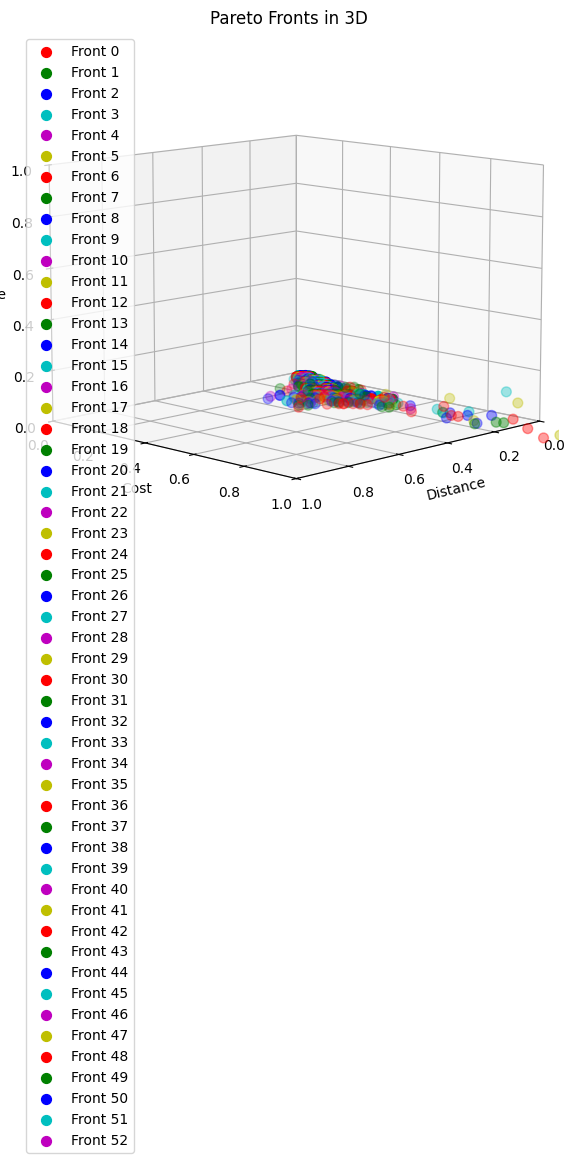

     3 |     1497 |      9 |  0.5000000000 |         nadir
pareto front 0
[[0.   4.92 0.23]
 [0.   3.71 0.85]
 [0.   3.94 0.8 ]
 [0.   4.72 0.37]
 [0.   4.62 0.61]
 [0.   4.62 0.61]
 [0.05 2.4  0.16]
 [0.06 1.97 0.33]
 [0.09 0.3  0.01]
 [0.07 2.31 0.01]
 [0.34 0.22 0.  ]
 [0.11 0.41 0.  ]
 [0.11 0.41 0.  ]
 [0.1  0.43 0.  ]
 [0.11 0.41 0.  ]
 [0.13 0.3  0.  ]
 [0.12 0.31 0.  ]
 [0.14 0.28 0.  ]
 [0.14 0.28 0.  ]
 [0.17 0.26 0.  ]
 [0.16 0.27 0.  ]
 [0.22 0.25 0.  ]
 [0.2  0.25 0.01]
 [0.28 0.24 0.  ]
 [0.08 0.94 0.12]
 [0.09 0.49 0.  ]
 [0.08 1.66 0.1 ]]
--------------------------
pareto front 1
[[0.   3.86 0.63]
 [0.   4.54 0.32]
 [0.   4.44 0.41]
 [0.   4.42 0.59]
 [0.   4.42 0.59]
 [0.02 2.08 0.12]
 [0.03 1.94 0.11]
 [0.05 1.69 0.22]
 [0.06 1.93 0.18]
 [0.06 1.56 0.19]
 [0.09 0.27 0.01]
 [0.07 2.11 0.01]
 [0.31 0.2  0.  ]
 [0.11 0.33 0.  ]
 [0.1  0.4  0.  ]
 [0.12 0.29 0.  ]
 [0.14 0.27 0.  ]
 [0.16 0.26 0.  ]
 [0.14 0.17 0.01]
 [0.12 0.23 0.01]
 [0.17 0.25 0.  ]
 [0.28 0.21 0.  ]
 

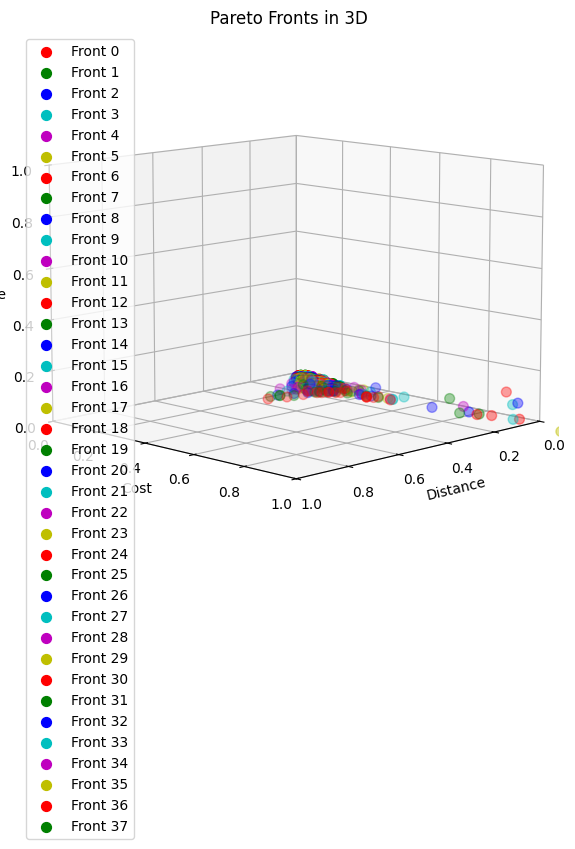

     4 |     1997 |     13 |  0.000000E+00 |             f
pareto front 0
[[0.   4.92 0.23]
 [0.   3.71 0.85]
 [0.   3.71 0.85]
 [0.   3.94 0.8 ]
 [0.   3.94 0.8 ]
 [0.   4.72 0.37]
 [0.   4.62 0.61]
 [0.   4.62 0.61]
 [0.02 2.08 0.12]
 [0.03 1.94 0.11]
 [0.03 1.97 0.01]
 [0.04 0.95 0.07]
 [0.21 0.14 0.  ]
 [0.05 0.37 0.02]
 [0.12 0.18 0.01]
 [0.19 0.16 0.  ]
 [0.13 0.18 0.  ]
 [0.14 0.17 0.01]
 [0.05 2.03 0.  ]
 [0.15 0.17 0.  ]
 [0.05 1.15 0.01]
 [0.06 0.43 0.  ]
 [0.07 0.25 0.  ]
 [0.1  0.22 0.  ]
 [0.12 0.2  0.  ]
 [0.09 0.23 0.  ]
 [0.06 0.34 0.01]]
--------------------------
pareto front 1
[[0.   3.86 0.63]
 [0.   4.54 0.32]
 [0.   4.44 0.41]
 [0.   4.42 0.59]
 [0.   4.42 0.59]
 [0.04 0.93 0.06]
 [0.11 0.18 0.01]
 [0.16 0.14 0.  ]
 [0.03 2.01 0.  ]
 [0.04 1.47 0.  ]
 [0.15 0.16 0.  ]
 [0.15 0.16 0.  ]
 [0.14 0.17 0.  ]
 [0.14 0.17 0.  ]
 [0.05 0.81 0.  ]
 [0.07 0.24 0.  ]
 [0.07 0.24 0.  ]
 [0.1  0.21 0.  ]
 [0.11 0.2  0.  ]
 [0.08 0.23 0.  ]
 [0.08 0.23 0.  ]
 [0.09 0.22 0.  ]
 

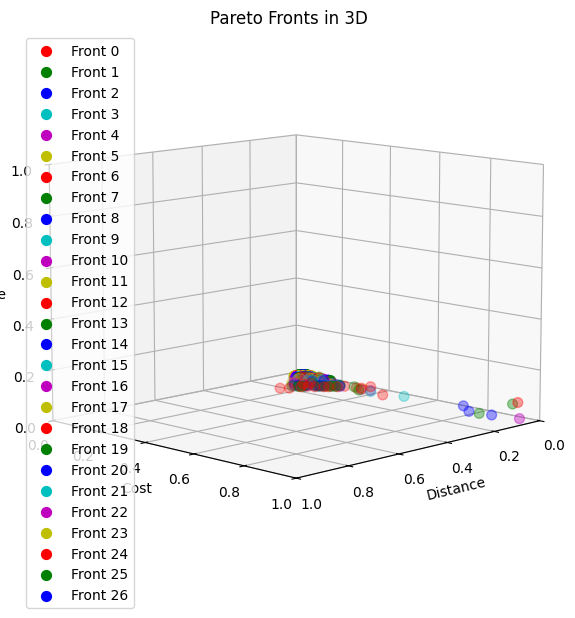

     5 |     2497 |     17 |  0.000000E+00 |             f
pareto front 0
[[0.   4.92 0.23]
 [0.   3.71 0.85]
 [0.   3.71 0.85]
 [0.   3.94 0.8 ]
 [0.   3.94 0.8 ]
 [0.   4.72 0.37]
 [0.   4.62 0.61]
 [0.   4.62 0.61]
 [0.02 2.08 0.12]
 [0.03 2.01 0.  ]
 [0.03 1.94 0.11]
 [0.03 1.97 0.01]
 [0.08 0.15 0.01]
 [0.13 0.12 0.  ]
 [0.13 0.12 0.  ]
 [0.09 0.14 0.01]
 [0.06 0.18 0.01]
 [0.04 0.75 0.  ]
 [0.12 0.13 0.  ]
 [0.05 0.21 0.  ]
 [0.09 0.16 0.  ]
 [0.1  0.15 0.  ]
 [0.11 0.14 0.  ]
 [0.07 0.18 0.  ]
 [0.06 0.19 0.  ]
 [0.09 0.16 0.  ]
 [0.08 0.17 0.  ]
 [0.08 0.17 0.  ]
 [0.07 0.18 0.  ]
 [0.06 0.19 0.  ]
 [0.07 0.18 0.  ]]
--------------------------
pareto front 1
[[0.   3.86 0.63]
 [0.   4.54 0.32]
 [0.   4.44 0.41]
 [0.   4.42 0.59]
 [0.   4.42 0.59]
 [0.02 0.21 0.02]
 [0.02 1.74 0.  ]
 [0.03 0.73 0.01]
 [0.03 1.56 0.  ]
 [0.13 0.11 0.  ]
 [0.09 0.13 0.01]
 [0.06 0.17 0.01]
 [0.04 0.36 0.  ]
 [0.05 0.2  0.  ]
 [0.11 0.13 0.  ]
 [0.09 0.15 0.  ]
 [0.09 0.15 0.  ]
 [0.08 0.16 0.  ]
 

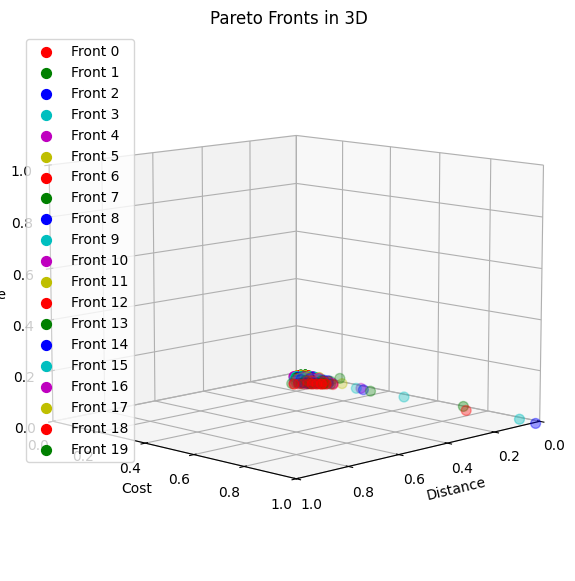

     6 |     2997 |     23 |  0.000000E+00 |             f
pareto front 0
[[0.01 2.02 0.15]
 [0.   4.92 0.23]
 [0.   4.92 0.23]
 [0.   3.71 0.85]
 [0.   3.71 0.85]
 [0.   3.94 0.8 ]
 [0.   3.94 0.8 ]
 [0.02 0.21 0.02]
 [0.   4.72 0.37]
 [0.02 0.25 0.01]
 [0.   4.62 0.61]
 [0.   4.62 0.61]
 [0.11 0.1  0.  ]
 [0.09 0.11 0.01]
 [0.1  0.11 0.  ]
 [0.07 0.13 0.01]
 [0.02 1.67 0.  ]
 [0.03 0.49 0.  ]
 [0.09 0.12 0.  ]
 [0.05 0.15 0.01]
 [0.04 0.18 0.  ]
 [0.06 0.15 0.  ]
 [0.05 0.17 0.  ]
 [0.07 0.14 0.  ]
 [0.04 0.18 0.  ]
 [0.08 0.13 0.  ]
 [0.05 0.17 0.  ]
 [0.07 0.14 0.  ]
 [0.06 0.15 0.  ]
 [0.08 0.13 0.  ]
 [0.09 0.12 0.  ]]
--------------------------
pareto front 1
[[0.   3.86 0.63]
 [0.   4.54 0.32]
 [0.   4.44 0.41]
 [0.   4.42 0.59]
 [0.   4.42 0.59]
 [0.   4.44 0.41]
 [0.1  0.1  0.  ]
 [0.06 0.12 0.01]
 [0.07 0.11 0.01]
 [0.02 0.94 0.  ]
 [0.03 0.31 0.  ]
 [0.04 0.14 0.01]
 [0.04 0.14 0.01]
 [0.04 0.17 0.  ]
 [0.05 0.15 0.  ]
 [0.06 0.14 0.  ]
 [0.06 0.14 0.  ]
 [0.07 0.13 0.  ]
 

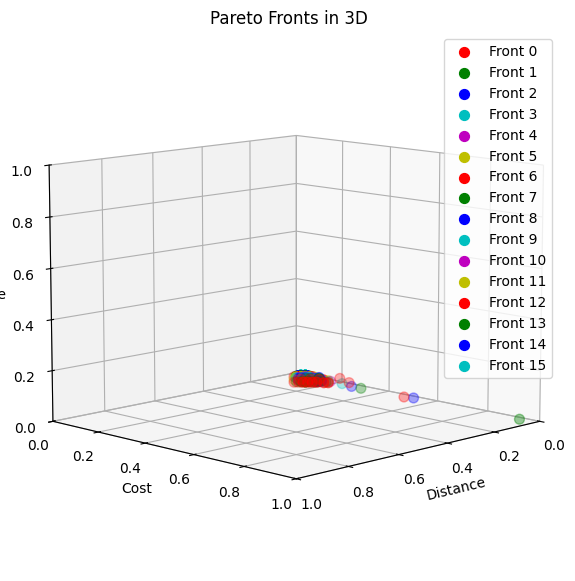

     7 |     3497 |     29 |  0.000000E+00 |             f
pareto front 0
[[0.01 2.02 0.15]
 [0.   4.92 0.23]
 [0.   4.92 0.23]
 [0.   3.71 0.85]
 [0.   3.71 0.85]
 [0.   3.99 0.52]
 [0.   3.99 0.52]
 [0.   3.94 0.8 ]
 [0.   3.94 0.8 ]
 [0.07 0.09 0.01]
 [0.   4.54 0.32]
 [0.02 0.22 0.  ]
 [0.   4.22 0.45]
 [0.1  0.09 0.  ]
 [0.   4.22 0.45]
 [0.02 0.21 0.02]
 [0.03 0.17 0.  ]
 [0.08 0.1  0.  ]
 [0.   4.42 0.38]
 [0.   4.42 0.38]
 [0.06 0.12 0.  ]
 [0.04 0.13 0.01]
 [0.07 0.11 0.  ]
 [0.04 0.14 0.  ]
 [0.08 0.1  0.  ]
 [0.07 0.11 0.  ]
 [0.05 0.13 0.  ]
 [0.05 0.13 0.  ]
 [0.06 0.11 0.01]
 [0.05 0.12 0.01]
 [0.04 0.14 0.  ]
 [0.07 0.11 0.  ]]
--------------------------
pareto front 1
[[0.   3.86 0.63]
 [0.   4.47 0.28]
 [0.   4.04 0.4 ]
 [0.   4.04 0.4 ]
 [0.02 0.17 0.  ]
 [0.   4.06 0.36]
 [0.   4.06 0.36]
 [0.   4.19 0.35]
 [0.   4.34 0.31]
 [0.   4.34 0.31]
 [0.03 0.13 0.01]
 [0.03 0.13 0.01]
 [0.08 0.09 0.  ]
 [0.08 0.09 0.  ]
 [0.08 0.09 0.  ]
 [0.08 0.09 0.  ]
 [0.06 0.1  0.01]
 

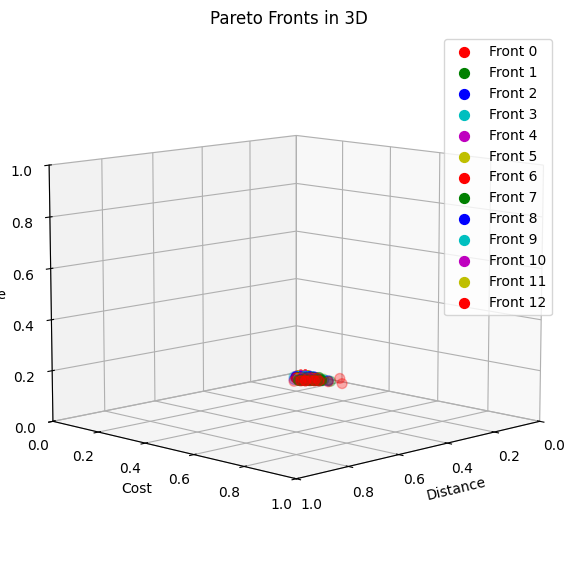

     8 |     3997 |     33 |  0.0011360784 |             f
pareto front 0
[[0.01 2.02 0.15]
 [0.   4.92 0.23]
 [0.   4.92 0.23]
 [0.08 0.07 0.  ]
 [0.   4.47 0.26]
 [0.   4.47 0.26]
 [0.   4.22 0.28]
 [0.07 0.09 0.  ]
 [0.02 0.16 0.  ]
 [0.   3.71 0.85]
 [0.07 0.09 0.  ]
 [0.   3.71 0.85]
 [0.02 0.16 0.  ]
 [0.   3.86 0.63]
 [0.05 0.1  0.01]
 [0.   3.94 0.38]
 [0.05 0.11 0.  ]
 [0.06 0.1  0.  ]
 [0.05 0.11 0.  ]
 [0.04 0.12 0.  ]
 [0.03 0.13 0.01]
 [0.04 0.12 0.  ]
 [0.03 0.14 0.  ]
 [0.06 0.09 0.01]
 [0.   4.01 0.31]
 [0.   3.94 0.38]
 [0.   4.12 0.3 ]
 [0.   4.01 0.31]
 [0.03 0.13 0.01]
 [0.03 0.14 0.  ]
 [0.05 0.1  0.01]
 [0.07 0.09 0.  ]
 [0.04 0.12 0.  ]
 [0.07 0.09 0.  ]
 [0.04 0.12 0.  ]
 [0.04 0.12 0.  ]
 [0.03 0.14 0.  ]
 [0.04 0.12 0.  ]
 [0.03 0.14 0.  ]
 [0.04 0.12 0.  ]
 [0.05 0.11 0.  ]
 [0.05 0.11 0.  ]
 [0.03 0.14 0.  ]
 [0.04 0.12 0.  ]
 [0.07 0.09 0.  ]
 [0.03 0.14 0.  ]
 [0.04 0.12 0.  ]
 [0.07 0.09 0.  ]
 [0.05 0.11 0.  ]
 [0.04 0.12 0.  ]
 [0.07 0.09 0.  ]]
-------

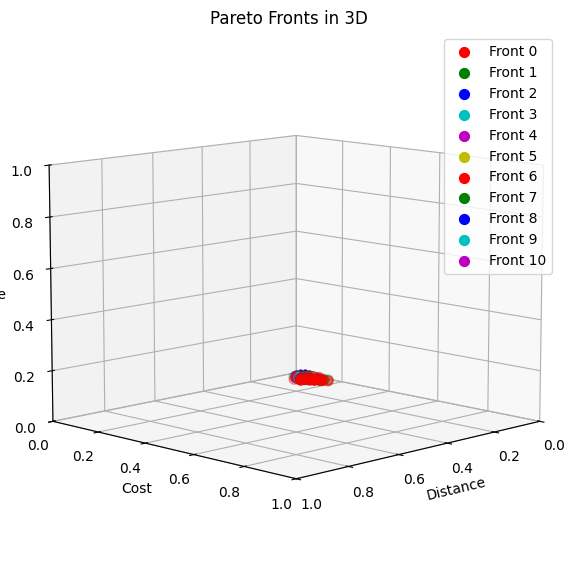

     9 |     4497 |     37 |  0.0010132591 |             f
pareto front 0
[[0.   4.92 0.23]
 [0.   4.92 0.23]
 [0.01 2.02 0.15]
 [0.01 1.94 0.32]
 [0.08 0.07 0.  ]
 [0.   4.47 0.26]
 [0.   4.47 0.26]
 [0.   3.94 0.38]
 [0.02 0.14 0.  ]
 [0.   3.71 0.85]
 [0.   4.22 0.28]
 [0.07 0.09 0.  ]
 [0.07 0.09 0.  ]
 [0.   3.71 0.85]
 [0.02 0.14 0.  ]
 [0.   3.76 0.54]
 [0.   4.12 0.3 ]
 [0.05 0.1  0.01]
 [0.   3.84 0.5 ]
 [0.   3.94 0.38]
 [0.05 0.11 0.  ]
 [0.06 0.09 0.01]
 [0.04 0.12 0.  ]]
--------------------------
pareto front 1
[[0.01 0.15 0.  ]
 [0.   4.37 0.26]
 [0.   4.39 0.25]
 [0.   4.14 0.27]
 [0.   4.14 0.27]
 [0.07 0.08 0.  ]
 [0.07 0.08 0.  ]
 [0.   3.51 0.63]
 [0.02 0.13 0.  ]
 [0.   4.04 0.28]
 [0.   3.99 0.29]
 [0.   3.99 0.29]
 [0.   4.04 0.28]
 [0.   3.69 0.39]
 [0.   3.89 0.38]
 [0.05 0.1  0.  ]
 [0.05 0.1  0.  ]
 [0.05 0.1  0.  ]
 [0.05 0.1  0.  ]
 [0.05 0.1  0.  ]
 [0.05 0.1  0.  ]
 [0.05 0.1  0.  ]
 [0.05 0.09 0.01]
 [0.05 0.09 0.01]
 [0.06 0.09 0.  ]
 [0.05 0.09 0.01]
 

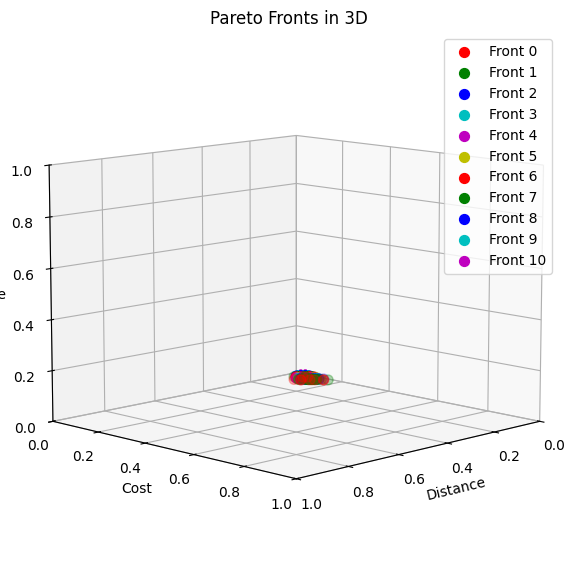

    10 |     4997 |      8 |  1.0000000000 |         nadir
pareto front 0
[[0.   4.14 0.27]
 [0.   4.14 0.27]
 [0.   3.51 0.63]
 [0.01 0.15 0.  ]
 [0.08 0.07 0.  ]
 [0.   4.92 0.23]
 [0.05 0.08 0.01]
 [0.   3.69 0.39]
 [0.   4.92 0.23]
 [0.06 0.08 0.  ]
 [0.   3.89 0.38]
 [0.   4.04 0.28]
 [0.   4.39 0.25]
 [0.   3.99 0.29]
 [0.05 0.09 0.  ]
 [0.02 0.12 0.  ]
 [0.04 0.1  0.  ]
 [0.04 0.1  0.  ]
 [0.03 0.11 0.  ]
 [0.02 0.12 0.  ]
 [0.03 0.11 0.  ]
 [0.06 0.08 0.  ]
 [0.   4.37 0.26]
 [0.   4.04 0.28]
 [0.   3.99 0.29]
 [0.05 0.09 0.  ]
 [0.04 0.1  0.  ]
 [0.03 0.11 0.  ]
 [0.04 0.1  0.  ]
 [0.05 0.09 0.  ]
 [0.02 0.12 0.  ]
 [0.05 0.09 0.  ]
 [0.06 0.08 0.  ]
 [0.06 0.08 0.  ]
 [0.06 0.08 0.  ]
 [0.04 0.1  0.  ]
 [0.03 0.11 0.  ]
 [0.05 0.09 0.  ]
 [0.04 0.1  0.  ]
 [0.06 0.08 0.  ]
 [0.05 0.09 0.  ]]
--------------------------
pareto front 1
[[0.   3.46 0.6 ]
 [0.01 0.14 0.  ]
 [0.   3.69 0.37]
 [0.   4.34 0.23]
 [0.   3.99 0.28]
 [0.02 0.11 0.  ]
 [0.02 0.11 0.  ]
 [0.02 0.11 0.  ]
 

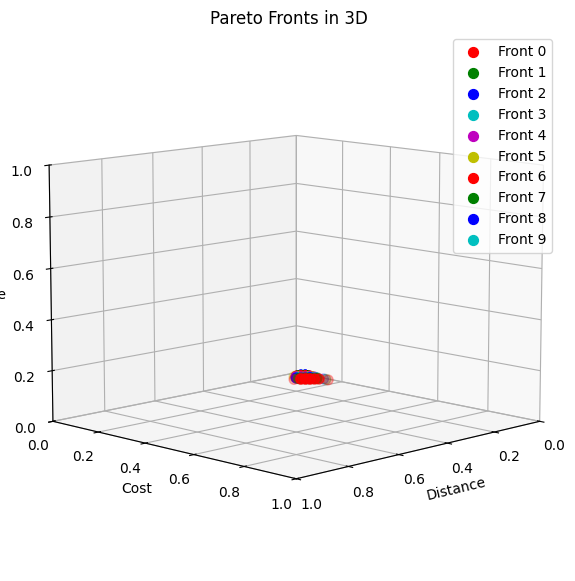

    11 |     5497 |      2 |  0.8297872340 |         nadir
pareto front 0
[[0.02 0.11 0.  ]
 [0.02 0.11 0.  ]
 [0.02 0.11 0.  ]
 [0.02 0.11 0.  ]
 [0.02 0.11 0.  ]
 [0.   3.46 0.6 ]
 [0.   4.34 0.23]
 [0.01 0.15 0.  ]
 [0.07 0.07 0.  ]
 [0.   3.69 0.37]
 [0.05 0.08 0.01]
 [0.   3.99 0.28]
 [0.   4.14 0.27]
 [0.04 0.1  0.  ]
 [0.05 0.08 0.01]]
--------------------------
pareto front 1
[[0.   3.11 0.5 ]
 [0.   3.11 0.5 ]
 [0.   3.18 0.46]
 [0.   3.18 0.46]
 [0.   3.38 0.39]
 [0.   3.38 0.39]
 [0.   4.29 0.22]
 [0.01 0.14 0.  ]
 [0.06 0.07 0.  ]
 [0.06 0.07 0.  ]
 [0.06 0.07 0.  ]
 [0.   3.51 0.35]
 [0.   3.51 0.35]
 [0.   3.69 0.32]
 [0.   3.69 0.32]
 [0.   3.96 0.27]
 [0.03 0.1  0.  ]
 [0.03 0.1  0.  ]
 [0.03 0.1  0.  ]
 [0.03 0.1  0.  ]
 [0.04 0.09 0.  ]
 [0.04 0.09 0.  ]
 [0.04 0.09 0.  ]
 [0.04 0.09 0.  ]
 [0.04 0.09 0.  ]
 [0.04 0.09 0.  ]
 [0.04 0.09 0.  ]
 [0.04 0.09 0.  ]
 [0.05 0.08 0.  ]
 [0.05 0.08 0.  ]
 [0.05 0.08 0.  ]]
--------------------------
pareto front 2
[[0.   3.23 

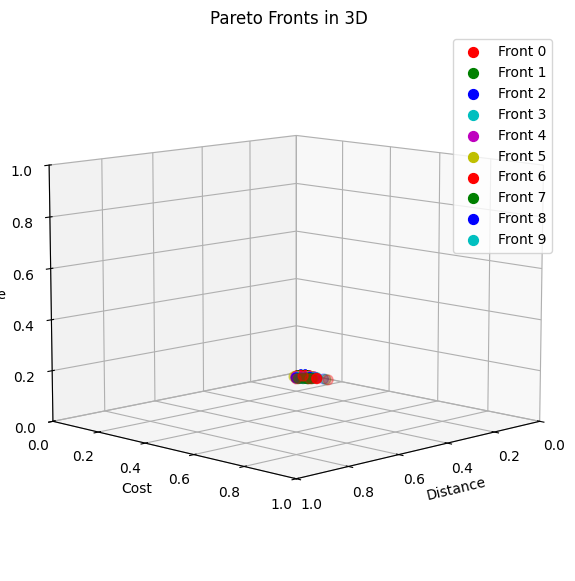

    12 |     5997 |      3 |  0.000000E+00 |             f
pareto front 0
[[0.   3.11 0.5 ]
 [0.   3.11 0.5 ]
 [0.   3.18 0.46]
 [0.   3.23 0.39]
 [0.   3.18 0.46]
 [0.   4.12 0.19]
 [0.   3.38 0.38]
 [0.   3.51 0.35]
 [0.   4.01 0.22]
 [0.06 0.06 0.  ]
 [0.01 0.13 0.  ]
 [0.06 0.06 0.  ]
 [0.   3.38 0.38]
 [0.04 0.08 0.  ]
 [0.   4.01 0.22]
 [0.   3.94 0.27]
 [0.02 0.1  0.  ]
 [0.   3.69 0.3 ]
 [0.03 0.09 0.  ]
 [0.05 0.07 0.  ]
 [0.04 0.08 0.  ]
 [0.03 0.09 0.  ]
 [0.05 0.07 0.  ]
 [0.   3.51 0.35]
 [0.   3.69 0.3 ]
 [0.03 0.09 0.  ]
 [0.03 0.09 0.  ]
 [0.03 0.09 0.  ]
 [0.06 0.06 0.  ]
 [0.03 0.09 0.  ]
 [0.06 0.06 0.  ]
 [0.04 0.08 0.  ]]
--------------------------
pareto front 1
[[0.   3.   0.37]
 [0.   3.13 0.36]
 [0.   3.   0.37]
 [0.   3.13 0.36]
 [0.   3.71 0.27]
 [0.   3.94 0.21]
 [0.   3.86 0.26]
 [0.01 0.1  0.  ]
 [0.01 0.1  0.  ]
 [0.   3.36 0.35]
 [0.   3.36 0.35]
 [0.   3.38 0.3 ]
 [0.   3.61 0.28]
 [0.   3.53 0.29]
 [0.   3.53 0.29]
 [0.02 0.09 0.  ]
 [0.02 0.09 0.  ]
 

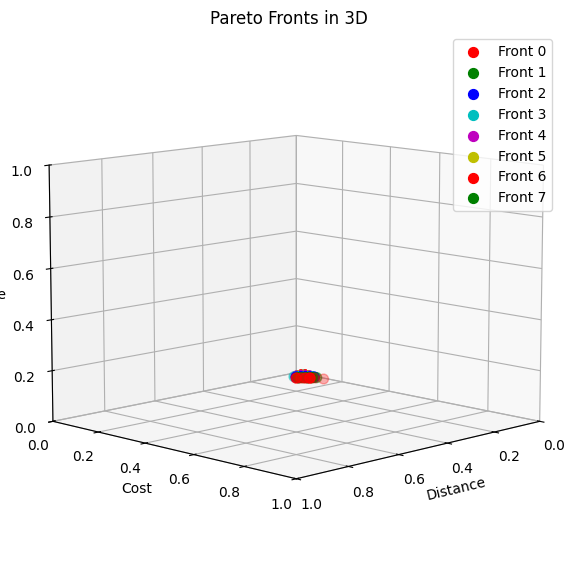

    13 |     6497 |      4 |  0.0052910053 |         ideal
pareto front 0
[[0.   3.71 0.27]
 [0.   3.51 0.28]
 [0.   3.11 0.5 ]
 [0.   3.11 0.5 ]
 [0.   3.38 0.3 ]
 [0.   3.43 0.29]
 [0.   3.18 0.46]
 [0.   3.23 0.39]
 [0.   3.18 0.46]
 [0.   4.12 0.19]
 [0.01 0.09 0.  ]
 [0.01 0.09 0.  ]
 [0.01 0.09 0.  ]
 [0.01 0.09 0.  ]
 [0.01 0.09 0.  ]
 [0.01 0.09 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.02 0.08 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0

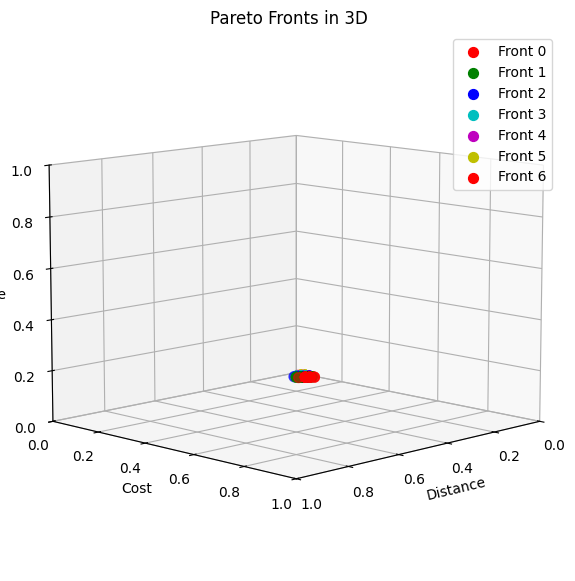

    14 |     6997 |      5 |  0.000000E+00 |             f
pareto front 0
[[0.01 0.09 0.  ]
 [0.05 0.05 0.  ]
 [0.   3.11 0.5 ]
 [0.   3.71 0.27]
 [0.05 0.05 0.  ]
 [0.   4.12 0.19]
 [0.01 0.09 0.  ]
 [0.   3.11 0.5 ]
 [0.02 0.08 0.  ]
 [0.   3.23 0.39]
 [0.   3.81 0.2 ]
 [0.04 0.06 0.  ]
 [0.03 0.07 0.  ]
 [0.04 0.06 0.  ]
 [0.02 0.08 0.  ]
 [0.03 0.07 0.  ]
 [0.   3.33 0.31]
 [0.   3.18 0.46]
 [0.   3.51 0.28]
 [0.   3.18 0.46]
 [0.   3.43 0.29]
 [0.   3.38 0.3 ]
 [0.   3.33 0.31]
 [0.   3.81 0.2 ]
 [0.05 0.05 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.05 0.05 0.  ]
 [0.04 0.06 0.  ]
 [0.05 0.05 0.  ]
 [0.03 0.07 0.  ]
 [0.04 0.06 0.  ]
 [0.02 0.08 0.  ]
 [0.03 0.07 0.  ]
 [0.04 0.06 0.  ]
 [0.03 0.07 0.  ]
 [0.03 0.07 0.  ]
 [0.05 0.05 0.  ]
 [0.03 0.07 0.  ]
 [0.04 0.06 0.  ]
 [0.04 0.06 0.  ]
 [0.03 0.07 0.  ]
 [0.04 0.06 0.  ]
 [0.05 0.05 0.  ]
 [0.03 0.07 0.  ]
 [0.04 0.06 0.  ]
 [0.03 0.07 0.  ]
 [0.01 0.09 0.  ]
 [0.04 0.06 0.  ]
 [0.01 0.09 0.  ]]
-------------------------

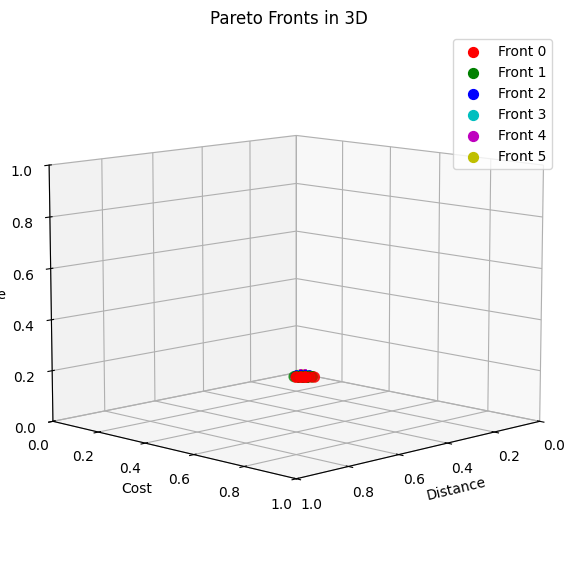

    15 |     7497 |      6 |  9.350000E+01 |         nadir
pareto front 0
[[0.   3.   0.37]
 [0.   3.43 0.26]
 [0.05 0.05 0.  ]
 [0.   3.79 0.19]
 [0.05 0.05 0.  ]
 [0.01 0.09 0.  ]
 [0.01 0.09 0.  ]
 [0.   3.   0.37]
 [0.04 0.06 0.  ]
 [0.   3.79 0.19]
 [0.   3.16 0.29]
 [0.   3.13 0.36]
 [0.03 0.07 0.  ]
 [0.04 0.06 0.  ]]
--------------------------
pareto front 1
[[0.   3.43 0.24]
 [0.05 0.04 0.  ]
 [0.05 0.04 0.  ]
 [0.05 0.04 0.  ]
 [0.05 0.04 0.  ]
 [0.01 0.08 0.  ]
 [0.01 0.08 0.  ]
 [0.01 0.08 0.  ]
 [0.01 0.08 0.  ]
 [0.01 0.08 0.  ]
 [0.01 0.08 0.  ]
 [0.01 0.08 0.  ]
 [0.01 0.08 0.  ]
 [0.01 0.08 0.  ]
 [0.   3.59 0.19]
 [0.   3.   0.26]
 [0.   3.   0.26]
 [0.   2.93 0.29]
 [0.   2.93 0.29]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 

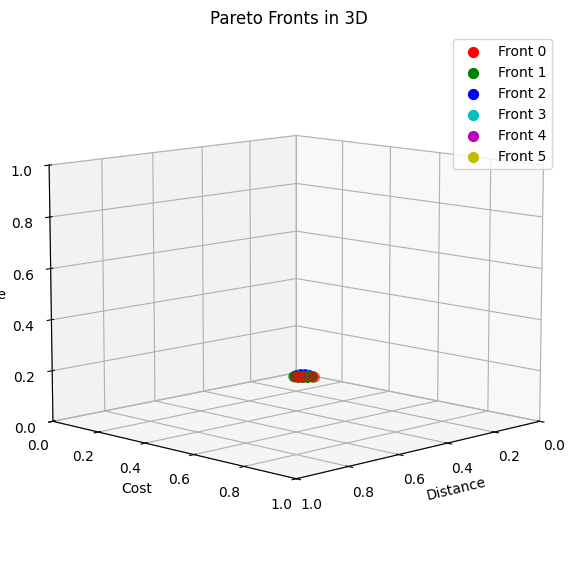

    16 |     7997 |      9 |  0.000000E+00 |             f
pareto front 0
[[0.   3.   0.26]
 [0.   3.   0.26]
 [0.   3.59 0.19]
 [0.05 0.04 0.  ]
 [0.05 0.04 0.  ]
 [0.   2.93 0.29]
 [0.   3.43 0.24]
 [0.01 0.08 0.  ]
 [0.   2.93 0.29]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.04 0.05 0.  ]
 [0.01 0.08 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.04 0.05 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.02 0.07 0.  ]
 [0.04 0

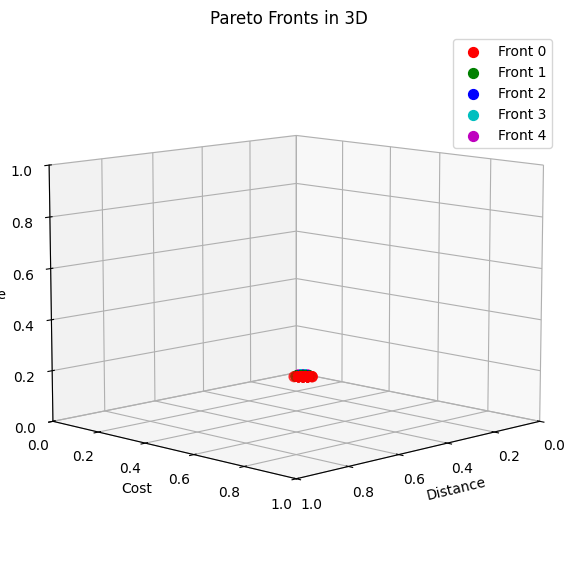

    17 |     8497 |     12 |  0.000000E+00 |             f
pareto front 0
[[0.   3.   0.26]
 [0.   3.   0.26]
 [0.05 0.04 0.  ]
 [0.   2.93 0.29]
 [0.01 0.08 0.  ]
 [0.   3.59 0.19]
 [0.   3.43 0.24]
 [0.05 0.04 0.  ]
 [0.01 0.08 0.  ]
 [0.   2.93 0.29]
 [0.04 0.05 0.  ]
 [0.04 0.05 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.04 0.05 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.04 0.05 0.  ]
 [0.02 0.07 0.  ]
 [0.04 0.05 0.  ]
 [0.04 0.05 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.04 0.05 0.  ]
 [0.01 0.08 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.04 0.05 0.  ]
 [0.02 0.07 0.  ]
 [0.04 0.05 0.  ]
 [0.05 0.04 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.02 0.07 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.01 0

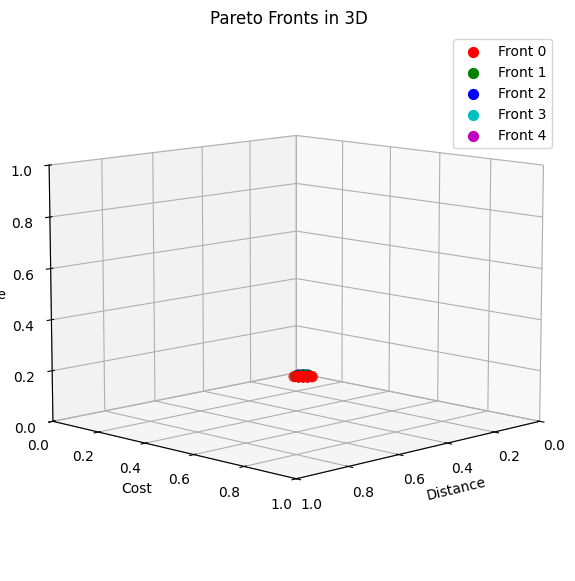

    18 |     8997 |     13 |  0.000000E+00 |             f
pareto front 0
[[0.   3.   0.26]
 [0.   3.   0.26]
 [0.   2.93 0.29]
 [0.   3.43 0.24]
 [0.05 0.04 0.  ]
 [0.05 0.04 0.  ]
 [0.   3.59 0.19]
 [0.01 0.08 0.  ]
 [0.01 0.08 0.  ]
 [0.   2.93 0.29]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.04 0.05 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.04 0.05 0.  ]
 [0.03 0.06 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]
 [0.04 0.05 0.  ]
 [0.02 0.07 0.  ]
 [0.01 0.08 0.  ]
 [0.02 0.07 0.  ]
 [0.03 0.06 0.  ]]
--------------------------
pareto front 1
[[0.   3.16 0.24]
 [0.   3.56 0.19]
 [0.   2.78 0.28]
 [0.   2.9  0.27]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 [0.04 0.04 0.  ]
 

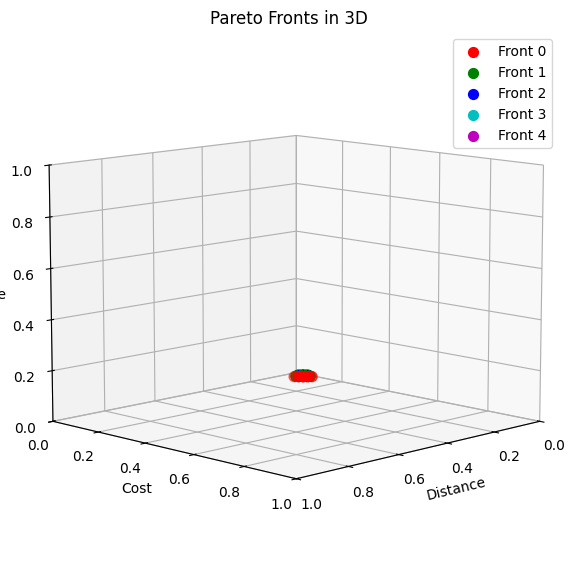

    19 |     9497 |     20 |  0.000000E+00 |             f
pareto front 0
[[0.   3.   0.26]
 [0.04 0.04 0.  ]
 [0.   2.78 0.28]
 [0.   3.56 0.19]
 [0.04 0.04 0.  ]
 [0.01 0.07 0.  ]
 [0.02 0.06 0.  ]
 [0.   3.16 0.24]
 [0.03 0.05 0.  ]
 [0.01 0.07 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.   2.9  0.27]
 [0.   3.   0.26]
 [0.04 0.04 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.01 0.07 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.01 0.07 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.01 0.07 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.04 0.04 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.01 0

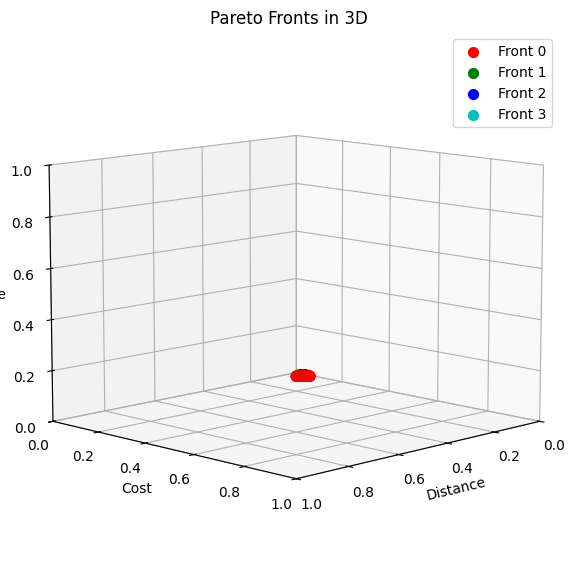

    20 |     9997 |     25 |  0.000000E+00 |             f
pareto front 0
[[0.04 0.04 0.  ]
 [0.   2.78 0.28]
 [0.04 0.04 0.  ]
 [0.   3.   0.26]
 [0.   3.56 0.19]
 [0.01 0.07 0.  ]
 [0.03 0.05 0.  ]
 [0.   3.16 0.24]
 [0.02 0.06 0.  ]
 [0.01 0.07 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.   2.9  0.27]
 [0.   3.   0.26]
 [0.04 0.04 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.01 0.07 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.04 0.04 0.  ]
 [0.03 0.05 0.  ]
 [0.01 0.07 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.01 0.07 0.  ]
 [0.03 0.05 0.  ]
 [0.04 0.04 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.04 0.04 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0

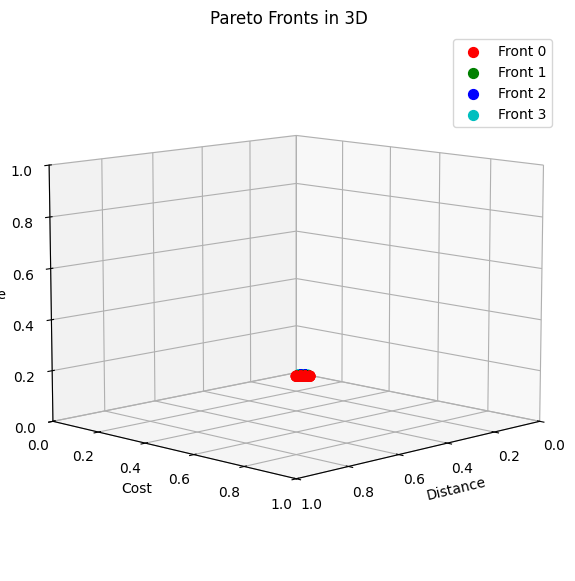

    21 |    10497 |      2 |  1.0000000000 |         nadir
pareto front 0
[[0.   3.56 0.19]
 [0.   3.43 0.26]
 [0.04 0.04 0.  ]
 [0.   3.38 0.39]
 [0.04 0.04 0.  ]
 [0.01 0.07 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.01 0.07 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.04 0.04 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.04 0.04 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.04 0.04 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.01 0.07 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.02 0.06 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.03 0.05 0.  ]
 [0.02 0

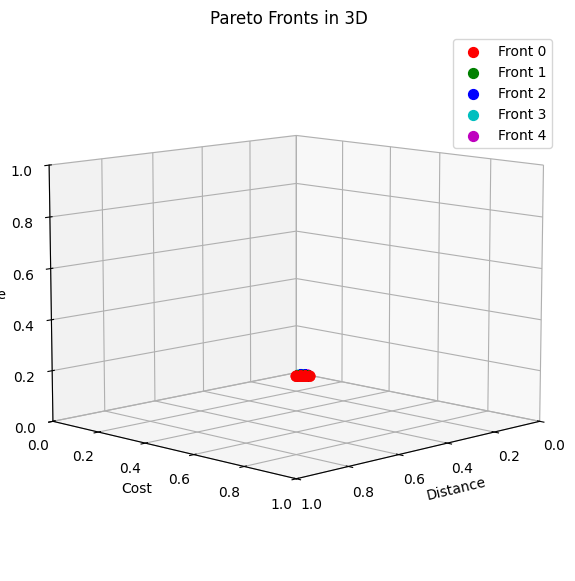

In [33]:
import random
import numpy as np
import folium
import matplotlib.pyplot as plt
import math
import ast
import plotly.graph_objects as go

from os import replace
from pymoo.core.crossover import Crossover
from pymoo.core.problem import Problem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.population import Population
from pymoo.core.crossover import Crossover
from pymoo.operators.selection.rnd  import RandomSelection
from pymoo.core.sampling import Sampling
from geopy.distance import geodesic
from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim
from pymoo.core.callback import Callback
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.core.selection import Selection
from pymoo.visualization.scatter import Scatter
from pymoo.core.mutation import Mutation
from mpl_toolkits import mplot3d
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from mpl_toolkits.mplot3d import Axes3D
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.util.dominator import Dominator
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from pymoo.termination.xtol import DesignSpaceTermination
from pymoo.termination.robust import RobustTermination
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def repairSolution(solution, n_var):
   solution = [int(row) for row in solution]

   sample = np.zeros(n_var)


   if(solution[0] != 0):

        length = solution[0] * GeneticAlgorithmConfig.timePlaceMappingSize
        head, interior, tail = getSliceRoute(solution)
        uniqueList = []

        for i in range(0, len(interior),GeneticAlgorithmConfig.timePlaceMappingSize):

          if(interior[i] not in uniqueList):
            for j in range(i, i+GeneticAlgorithmConfig.timePlaceMappingSize, 1):
              uniqueList.append(interior[j])
        lengthSolution = int((len(uniqueList) // GeneticAlgorithmConfig.timePlaceMappingSize))

        uniqueList = [lengthSolution] + head + uniqueList + tail
        return uniqueList

   else:
      return solution


def isValidSolution(solution):
   solution = [int(row) for row in solution]
   return True



def createSolution(n_var):
    hotel = locations[locations["type"] == "hotel"].sample(n=1)
    hotelId = hotel["Id"].values[0]

    sample = [-1 for _ in range(n_var)]
    rand = random.randint(0, GeneticAlgorithmConfig.totalRouteSize)
    time = 8
    if(userPreference["Resort"] == 5):
      time = 16
    currentLocationSize = rand
    start = GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * GeneticAlgorithmConfig.timePlaceMappingSize)
    end = (start + (rand * GeneticAlgorithmConfig.timePlaceMappingSize))
    sample[0] = currentLocationSize
    sample[1] = hotelId
    sample[2] = time
    sample[end] = hotelId
    sample[end+1] = time
    for i in range(start, end, GeneticAlgorithmConfig.timePlaceMappingSize):
      location = locations[locations["type"] != "hotel"].sample(n=1)
      sample[i] = location["Id"].values[0]
      time = np.random.randint(1, 8)
      sample[i+1] = time


    return sample

n_obj = 3
best_per_generation = []  # لیستی برای هر تابع هدف

def dominates(a, b):
    """بررسی اینکه آیا کروموزوم a بر کروموزوم b تسلط دارد یا خیر"""
    return np.all(a <= b) and np.any(a < b)

def fast_non_dominated_sort(F):
    num_points = F.shape[0]
    S = [[] for _ in range(num_points)]
    front = [[]]
    n = [0] * num_points
    rank = [0] * num_points

    for p in range(num_points):
        for q in range(num_points):
            if p != q:  # حذف مقایسه خودش با خودش
                p_dominates_q = np.all(F[p] >= F[q]) and np.any(F[p] > F[q])
                q_dominates_p = np.all(F[q] >= F[p]) and np.any(F[q] > F[p])

                if p_dominates_q:
                    S[p].append(q)
                elif q_dominates_p:
                    n[p] += 1

        if n[p] == 0:
            rank[p] = 0
            front[0].append(p)

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        front.append(Q)
    del front[-1]

    return front

class CustomeCallback(Callback):
    def __init__(self, n_obj):
        super().__init__()
        self.n_obj = n_obj


    def notify(self, algorithm):
        F = algorithm.pop.get("F")  # دریافت مقدار Fitness
        X = algorithm.pop.get("X")

        GeneticAlgorithmConfig.number_genrations = algorithm.n_gen

        # for sample in X:
        #    print(sample[0:(sample[0] * 2) + 5])
        # print('-------------------------')

        if algorithm.pop is not None:
            # scaler = MinMaxScaler(feature_range=(0, 1))
            # normalizedFitness = scaler.fit_transform(F)
            # format_func = np.vectorize(lambda x: float("%.2f" % x))

            # # اعمال فرمت‌دهی روی ماتریس
            # normalizedFitness = format_func(normalizedFitness)
            # algorithm.pop.set("F", normalizedFitness)

            # F = algorithm.pop.get("F")
            # print(F)
            pareto_indices = NonDominatedSorting().do(F, only_non_dominated_front=False)
            pareto_fronts = [F[idx] for idx in pareto_indices]
            pareto_solutions = [X[idx] for idx in pareto_indices]
            colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta']
            GeneticAlgorithmConfig.pareto_generations.append(pareto_fronts)


            pareto_fronts = fast_non_dominated_sort(F)

            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')

            colors = ['r', 'g', 'b', 'c', 'm', 'y']
            for i, front in enumerate(pareto_fronts):
                # print(front)
                print(f"pareto front {i}")
                front_points = F[front]
                print(front_points)
                print('--------------------------')
                ax.scatter(front_points[:, 0], front_points[:, 1], front_points[:, 2],
                          color=colors[i % len(colors)], label=f'Front {i}', s=50)
            ax.set_xlim3d(0, 1)
            ax.set_ylim3d(0, 1)
            ax.set_zlim3d(0, 1)
            ax.view_init(elev=10, azim=45)
            ax.set_title("Pareto Fronts in 3D")
            ax.set_xlabel("Distance")
            ax.set_ylabel("Cost")
            ax.set_zlabel("Rate")
            ax.set_title('Pareto Fronts in 3D')
            ax.legend()
            plt.show()
            # fig = plt.figure(figsize=(10, 10))
            # ax = fig.add_subplot(111, projection='3d')
            # for i, pareto in enumerate(pareto_fronts):
            #       ax.scatter(pareto[:, 0], pareto[:, 1], abs(pareto[:, 2]))





            # ax.view_init(elev=10, azim=45)
            # ax.set_title("Pareto Fronts in 3D")
            # ax.set_xlabel("Distance")
            # ax.set_ylabel("Cost")
            # ax.set_zlabel("Rate")
            # ax.set_xlim3d(0, 1)
            # ax.set_ylim3d(0, 1)
            # ax.set_zlim3d(0, 1)
            # # # حذف تکرار لیبل‌های رنگی
            # handles, labels = plt.gca().get_legend_handles_labels()
            # by_label = dict(zip(labels, handles))
            # plt.legend(by_label.values(), by_label.keys(), loc='upper left')

            # # # نمایش نمودار
            # plt.show()
            # format_func = np.vectorize(lambda x: "%.6f" % x)
            # # اعمال فرمت‌دهی روی ماتریس
            # formatted_matrix = format_func(F)

            # print(formatted_matrix)


            # # نمایش دسته‌بندی‌ها
            # for i, front in enumerate(pareto_fronts):
            #     if(i == 0):
            #       print(f"Pareto Front {i+1}:")
            #       print(f"index:{i+1}, {front}")
            # print('------------------------------')



            # for i, solutions in enumerate(pareto_solutions):
            #     if(i == 0):
            #       print(f"solution {i+1}:")
            #       count_route, total_distance, total_cost, total_rate = getSingleObjective(solutions,
            #                                                                                GeneticAlgorithmConfig.preference)

            #       for i in range(len(total_distance)):
            #          print(f"{count_route[i]}->({total_distance[i]}, {total_cost[i]}, {total_rate[i]})")

            # print('-------------------------')




            # print('//////////////////////////////////////////////')



class CustomMutation(Mutation):
    def __init__(self, change_rate=0.07, swap_rate=0.07, new_rate=0.07):
        super().__init__()
        self.change_rate = change_rate  # احتمال جهش
        self.swap_rate = swap_rate
        self.new_rate  = new_rate

    def _do(self, problem, X, **kwargs):
        X_mutated = X.copy()
        n, d = X.shape  # تعداد کروموزوم‌ها و متغیرها

        for i in range(n):

            if (np.random.rand() < self.change_rate):
                if X_mutated[i, 0] > 2:
                  j = np.random.randint(2, X_mutated[i, 0])  # انتخاب یک ژن تصادفی برای تغییر
                  if(j % 2 == 0):
                    j += 1
                  old = X_mutated[i, j]
                  X_mutated[i, j] = getLocation()
                  time = np.random.randint(1, 8)
                  X_mutated[i, j+1] = time
                  new = X_mutated[i, j]
                  # print(f"{old} -> {new}")
                  # print('------------------------')
            if(np.random.rand() < self.swap_rate):
                head, interior, tail = getSliceRoute(X_mutated[i])

                point1 = 0
                point2 = 0
                if(len(interior) > 1):
                   if(len(interior) == 4):

                      point1 = 0
                      point2 = 2
                      temp = interior[point1]
                      temp_time = interior[point1+1]
                      interior[point1] = interior[point2]
                      interior[point1+1] = interior[point2+1]
                      interior[point2] = temp
                      interior[point2+1] = temp_time

                      length = int(len(interior) // GeneticAlgorithmConfig.timePlaceMappingSize)
                      sample = [length] + list(head) + list(interior) + list(tail)
                      for j in range(len(sample)):
                          X_mutated[i, j] = sample[j]

                      # print(f"{interior[point1]} -> {interior[point2]}")
                      # print('------------------------------------')
                   elif(len(interior) > 4):


                      point1 = np.random.randint(0, len(interior)-2)
                      point2 = np.random.randint(0, len(interior)-2)


                      if(point1 % 2 != 0):
                         point1 += 1
                      if(point2 % 2 != 0):
                         point2 += 1
                      temp = interior[point1]
                      temp_time = interior[point1+1]
                      interior[point1] = interior[point2]
                      interior[point1+1] = interior[point2+1]
                      interior[point2] = temp
                      interior[point2+1] = temp_time

                      length = int(len(interior) // GeneticAlgorithmConfig.timePlaceMappingSize)


                      sample = [length] + list(head) + list(interior) + list(tail)
                      for j in range(len(sample)):
                          X_mutated[i, j] = sample[j]


            if(np.random.rand() < self.new_rate):
                  head, interior, tail = getSliceRoute(X_mutated[i])
                  old = X_mutated[i]
                  point = 0
                  newLocation = getLocation()
                  time = np.random.randint(1, 8)
                  if(len(interior) > 1):
                     point = np.random.randint(0, len(interior))
                     if(point % 2 != 0):
                        point += 1
                  interior = list(interior)
                  interior.insert(point, newLocation)
                  interior.insert(point+1, time)
                  length = len(interior) // GeneticAlgorithmConfig.timePlaceMappingSize
                  newRoute = [length] + list(head) + list(interior) + list(tail)
                  newRoute = repairSolution(newRoute, GeneticAlgorithmConfig.n_var)
                  # print(f"old: {old}")
                  # print(f"new: {newRoute}")
                  # print(f"value:{newLocation}, {time}")
                  # print('-----------------------------')
                  for j in range(len(newRoute)):
                      X_mutated[i, j] = newRoute[j]
        return X_mutated



class CustomSampling(Sampling):
    def __init__(self, prefernces, **kwargs):
        self.prefernces = prefernces
        super().__init__(**kwargs)

    def _do(self, problem, n_samples, **kwargs):
        n_var = problem.n_var  # تعداد متغیرها
        xl = problem.xl        # حد پایین متغیرها
        xu = problem.xu        # حد بالا متغیرها
        samples = np.zeros([n_samples, n_var], dtype=int)

        for row in range(len(samples)):
            samples[row] = createSolution(n_var)


        # for sample in samples:
        #    print(sample[0:(sample[0] * 2) + 5])
        # print('-------------------------------')
        return samples


def getObjective(routes, prefernces):
    total_distance = []
    total_cost = []
    total_rate = []
    T = 8 * 4



    for route in routes:

        deltaT = 0
        totalTime = 0
        M = 0
        L = route[0] + 1

        countHotel = 0
        route = route.astype(int)
        distance = 0
        cost = 0
        rate = 0
        averageRate = 0
        startRoute = 1
        endRoute  = (route[0] * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * 2)


        # calculate distance
        for i in range(startRoute, endRoute, GeneticAlgorithmConfig.timePlaceMappingSize):

            totalTime += route[i + 1]

            start, end = int(route[i]), int(route[i + GeneticAlgorithmConfig.timePlaceMappingSize])
            start = locations[locations["Id"] == start]
            end = locations[locations["Id"] == end]
            start_lat, start_lon = start["Latitude"].values[0], start["Longitude"].values[0]
            end_lat, end_lon = end["Latitude"].values[0], end["Longitude"].values[0]
            distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)
        if(GeneticAlgorithmConfig.number_genrations == 1):
          if(GeneticAlgorithmConfig.maxDistance < distance):
            GeneticAlgorithmConfig.maxDistance = distance

        detalT = abs(totalTime - T)
        M = L / detalT

        if(M != np.inf):
          distance /= M



        # caculate rate
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):
          averageRate = 0
          node = locations[locations["Id"] == route[i]]

          if(len(node["tag"]) > 0):
            tags = node["tag"].values[0]
            tags = str(tags).replace("[" ,"")
            tags = str(tags).replace("'" ,"")
            tags = str(tags).replace(']', "")
            tags = str(tags).replace(' ', "")
            tags = str(tags).split(',')

            for tag in tags:
              if(tag in prefernces):

                averageRate += node['Stars'].values[0] * prefernces[tag]
            averageRate /=  len(tags)
            rate += route[i+1] * averageRate
        if(GeneticAlgorithmConfig.number_genrations == 1):
          if(GeneticAlgorithmConfig.maxRate < rate):
            GeneticAlgorithmConfig.maxRate = rate
        rate = detalT / rate


        # caculate cost
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):

            node = locations[locations["Id"] == route[i]]
            cost += node["Price"].values[0]
        if(GeneticAlgorithmConfig.number_genrations == 1):
          if(GeneticAlgorithmConfig.maxCost < cost):
            GeneticAlgorithmConfig.maxCost = cost

        if(M != np.inf):
          cost /= M


        total_distance.append(distance)
        total_cost.append(cost)
        total_rate.append(rate)



    # if(GeneticAlgorithmConfig.maxDistance == -1):
    #         GeneticAlgorithmConfig.maxDistance = float(f"{max(total_distance):.2f}")
    #         print(f"maxDistance : {GeneticAlgorithmConfig.maxDistance}")

    # if(GeneticAlgorithmConfig.maxCost == -1):
    #     GeneticAlgorithmConfig.maxCost = float(f"{max(total_cost):.2f}")
    #     print(f"maxCost:{GeneticAlgorithmConfig.maxCost}")

    # if(GeneticAlgorithmConfig.maxRate == -1):
    #     GeneticAlgorithmConfig.maxRate = float(f"{max(total_rate):.2f}")
    #     print(f"maxRate:{GeneticAlgorithmConfig.maxRate}")


    for i in range(len(total_distance)):
      total_distance[i] /= GeneticAlgorithmConfig.maxDistance
      total_distance[i] = float(format(total_distance[i], ".2f"))


    for i in range(len(total_cost)):
      total_cost[i] /= GeneticAlgorithmConfig.maxCost
      total_cost[i] = float(format(total_cost[i], ".2f"))


    for i in range(len(total_rate)):
      total_rate[i] /= GeneticAlgorithmConfig.maxRate
      total_rate[i] = float(format(total_rate[i], ".2f"))



    array1 = np.array(total_distance)
    array2 = np.array(total_cost)
    array3 = np.array(total_rate)







    return (total_distance,
            total_cost,
            total_rate)



def getSingleObjective(routes, prefernces):

    total_distance = []
    total_cost = []
    total_rate = []
    count_route = []




    for route in routes:
        count_route.append(route[0])

        deltaT = 0
        totalTime = 0
        M = 0
        L = route[0] + 1

        countHotel = 0
        route = route.astype(int)
        distance = 0
        cost = 0
        rate = 0
        averageRate = 0
        startRoute = 1
        endRoute  = (route[0] * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * 2)


        # calculate distance
        for i in range(startRoute, endRoute, GeneticAlgorithmConfig.timePlaceMappingSize):

            totalTime += route[i + 1]

            start, end = int(route[i]), int(route[i + GeneticAlgorithmConfig.timePlaceMappingSize])
            start = locations[locations["Id"] == start]
            end = locations[locations["Id"] == end]
            start_lat, start_lon = start["Latitude"].values[0], start["Longitude"].values[0]
            end_lat, end_lon = end["Latitude"].values[0], end["Longitude"].values[0]
            distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)





        # caculate rate
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):
          averageRate = 0
          node = locations[locations["Id"] == route[i]]

          if(len(node["tag"]) > 0):
            tags = node["tag"].values[0]
            tags = str(tags).replace("[" ,"")
            tags = str(tags).replace("'" ,"")
            tags = str(tags).replace(']', "")
            tags = str(tags).replace(' ', "")
            tags = str(tags).split(',')
            # print(f"tag: {tags}")
            for tag in tags:
                # print(f"star: {node['Stars'].values[0]}")
                # print(f"wieght: {prefernces[tag]}")
                averageRate += node['Stars'].values[0] * prefernces[tag]
            averageRate /= len(tags)
            rate += averageRate
            rate += route[i+1] * averageRate

        # caculate cost
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):

            node = locations[locations["Id"] == route[i]]
            cost += node["Price"].values[0]


        # print(f'distance: {distance}')
        # print(f'cost: {cost}')
        # print(f'rate: {rate}')
        # print('-------------------')
        total_distance.append(distance)
        total_cost.append(cost)
        total_rate.append(rate)





    return (count_route,
            total_distance,
            total_cost,
            total_rate)



# مدل و الگوریتم NSGA-II
class HotelRouteProblem(Problem):
    def __init__(self, n_var, prefernces=None):
      self.prefernces = prefernces
      super().__init__(n_var=n_var,
                         n_obj=3,
                         n_constr=0,
                         xl=0,
                         xu=len(locations) - 1)

    def _evaluate(self, x, out, *args, **kwargs):
        total_distance, total_cost, total_rate = getObjective(x, self.prefernces)
        out["F"] = np.column_stack([total_distance, total_cost, total_rate])




class CustomeCrossover(Crossover):
    def __init__(self):


        super().__init__(2,2)

    def _do(self, problem, X, **kwargs):

        _, n_matings, n_var = X.shape
        Y = np.full_like(X, None, dtype=object)

        for k in range(n_matings):
            while True:
              # انتخاب والدین
              parent1 = [int(item) for item in X[0, k]]
              parent2 = [int(item) for item in X[1, k]]

              head1, interior1, tail1 = getSliceRoute(parent1)
              head2, interior2, tail2 = getSliceRoute(parent2)

              point1 = 0
              point2 = 0
              if((len(interior1) // GeneticAlgorithmConfig.timePlaceMappingSize) > 0):
                  point1  = np.random.randint(0, len(interior1) / GeneticAlgorithmConfig.timePlaceMappingSize)

              if((len(interior2) // GeneticAlgorithmConfig.timePlaceMappingSize) > 0):
                point2 = np.random.randint(0, len(interior2) / GeneticAlgorithmConfig.timePlaceMappingSize)




              child1 = interior1[:point1*GeneticAlgorithmConfig.timePlaceMappingSize] + interior2[point2*GeneticAlgorithmConfig.timePlaceMappingSize:]
              child2 = interior2[:point2*GeneticAlgorithmConfig.timePlaceMappingSize] + interior1[point1*GeneticAlgorithmConfig.timePlaceMappingSize:]

              lenChild1 = int(len(child1) // GeneticAlgorithmConfig.timePlaceMappingSize)
              lenChild2 = int(len(child2) // GeneticAlgorithmConfig.timePlaceMappingSize)



              child1 = [lenChild1] + head1 + child1 + tail1
              child2 = [lenChild2] + head2 + child2 + tail2

              # print(f"parent1: {parent1}")
              # print(f"parent2: {parent2}")

              # display(HTML(f"""</span><span style='color:green'>{interior1[:point1*GeneticAlgorithmConfig.timePlaceMappingSize]}</span>
              #   <span style='color:orange'>{interior2[point2*GeneticAlgorithmConfig.timePlaceMappingSize:]}</span>"""))
              # display(HTML(f"""</span><span style='color:orange'>{interior2[:point2*GeneticAlgorithmConfig.timePlaceMappingSize]}</span>
              #   <span style='color:green'>{interior1[point1*GeneticAlgorithmConfig.timePlaceMappingSize:]}</span>"""))
              # print(f"child1: {child1}")
              # print(f"child2: {child2}")
              # print('--------------------------')
              childSample1  = np.zeros(n_var)
              childSample2  = np.zeros(n_var)

              child1 = repairSolution(child1, n_var)
              child2 = repairSolution(child2, n_var)




              for i in range(len(child1)):
                childSample1[i] = child1[i]
              for i in range(len(child2)):
                  childSample2[i] = child2[i]
              break

            # ذخیره فرزندان
            Y[0, k] = childSample1
            Y[1, k] = childSample2

        return Y


n_var = GeneticAlgorithmConfig.n_var





# استفاده از انتخاب تورنمنت

GeneticAlgorithmConfig.preference = userPreference
algorithm = NSGA2(pop_size=500,
                  sampling=CustomSampling(prefernces=userPreference),
                  crossover=CustomeCrossover(),
                  callback=CustomeCallback(n_obj=3),
                  mutation=CustomMutation(),
                  )



termination = RobustTermination(DesignSpaceTermination(tol=0.01), period=20)

problem = HotelRouteProblem(n_var=n_var, prefernces=userPreference)
res = minimize(problem,
               algorithm,
               termination=termination,
               verbose=True,
               eliminate_duplicates=True)

import plotly.graph_objects as go


pareto_indices = NonDominatedSorting().do(res.F, only_non_dominated_front=False)

# دسته‌بندی پارتو
pareto_fronts = [res.F[idx] for idx in pareto_indices]

# for i in range(len(pareto_fronts[0])):
#   print(pareto_fronts[0][i])

pareto_solutions = [res.X[idx] for idx in pareto_indices]




# count, total_distance, total_cost, total_rate = getSingleObjective(pareto_solutions[0],GeneticAlgorithmConfig.preference)
# for i in range(len(total_distance)):
#         print(f"{count[i]}->({total_distance[i]}, {total_cost[i]}, {total_rate[i]})")


# # ایجاد نمودار ۳D با Plotly
# fig = go.Figure()


# x = res.F[:, 0]
# y = res.F[:, 1]
# z = abs(res.F[:, 2])

# # رسم نقاط برای هر جبهه
# fig.add_trace(go.Scatter3d(
#     x=x, y=y, z=z,
#     mode='markers',
#     marker=dict(size=5),
#     name=f'Pareto Front {i+1}'  # نام جبهه‌ها
# ))

# # تنظیمات نمایش نمودار
# fig.update_layout(
#     title='3D Scatter Plot of Pareto Fronts',
#     autosize=True,
#     scene=dict(
#         xaxis_title='Objective 1',
#         yaxis_title='Objective 2',
#         zaxis_title='Objective 3'
#     ),
#     showlegend=True
# )

# # نمایش نمودار به صورت قابل حرکت
# fig.show()

# print(GeneticAlgorithmConfig.pareto_generations)


# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)
# ax.set_xlabel("Objective 1")
# ax.set_ylabel("Objective 2")
# ax.set_zlabel("Objective 3")
# ax.set_title("Evolution of Pareto Fronts")




# best_index = np.argmin(res.F[:, 2])
# best_route = res.X[best_index].astype(int)
# best_distance = res.F[best_index, 0]
# best_cost = res.F[best_index, 1]
# best_rate = res.F[best_index, 2]



# print(res.F)

# print('---------------')
# print("Best Route (order of locations):", best_route)
# print("Best Distance:", best_distance)
# print("Best Cost:", best_cost)
# print("Best rate:", abs(best_rate))






In [30]:
import numpy as np

def fast_non_dominated_sort(F, epsilon=1e-9):
    num_points = F.shape[0]
    S = [[] for _ in range(num_points)]
    front = [[]]
    n = [0] * num_points
    rank = [0] * num_points

    for p in range(num_points):
        for q in range(num_points):
            if p != q:
                # شرط تسلط را اصلاح کردیم!
                p_dominates_q = np.all(F[p] >= F[q]) and np.any(F[p] > F[q])
                q_dominates_p = np.all(F[q] >= F[p]) and np.any(F[q] > F[p])

                if p_dominates_q:
                    S[p].append(q)
                elif q_dominates_p:
                    n[p] += 1

        if n[p] == 0:
            rank[p] = 0
            front[0].append(p)

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        front.append(Q)
    del front[-1]

    return front

# 📌 تست با داده‌های جدید
F = np.array([
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 1.0],
    [3.0, 1.0, 2.0],
    [3.0, 3.0, 3.0],
    [4.0, 2.0, 4.0],
    [1.1, 2.0, 5.0],
    [3.0, 4.0, 1.0],
    [2.5, 5.0, 2.0]
])

pareto_fronts = fast_non_dominated_sort(F)

# 📌 نمایش جبهه‌های پارتو
for i, front in enumerate(pareto_fronts):
    print(f"Front {i}: {F[front]}")


Front 0: [[3.  3.  3. ]
 [4.  2.  4. ]
 [1.1 2.  5. ]
 [3.  4.  1. ]
 [2.5 5.  2. ]]
Front 1: [[3.       1.       2.      ]
 [2.000001 2.       1.      ]]
Front 2: [[0.1 0.1 0.1]
 [0.1 0.1 0.1]]


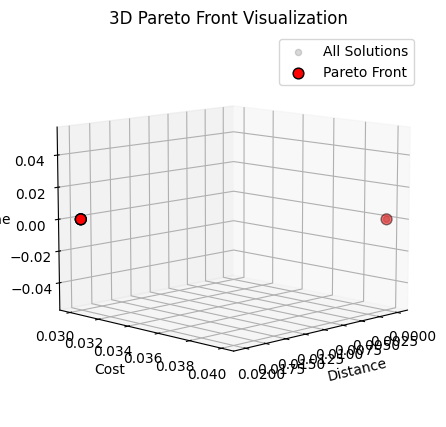

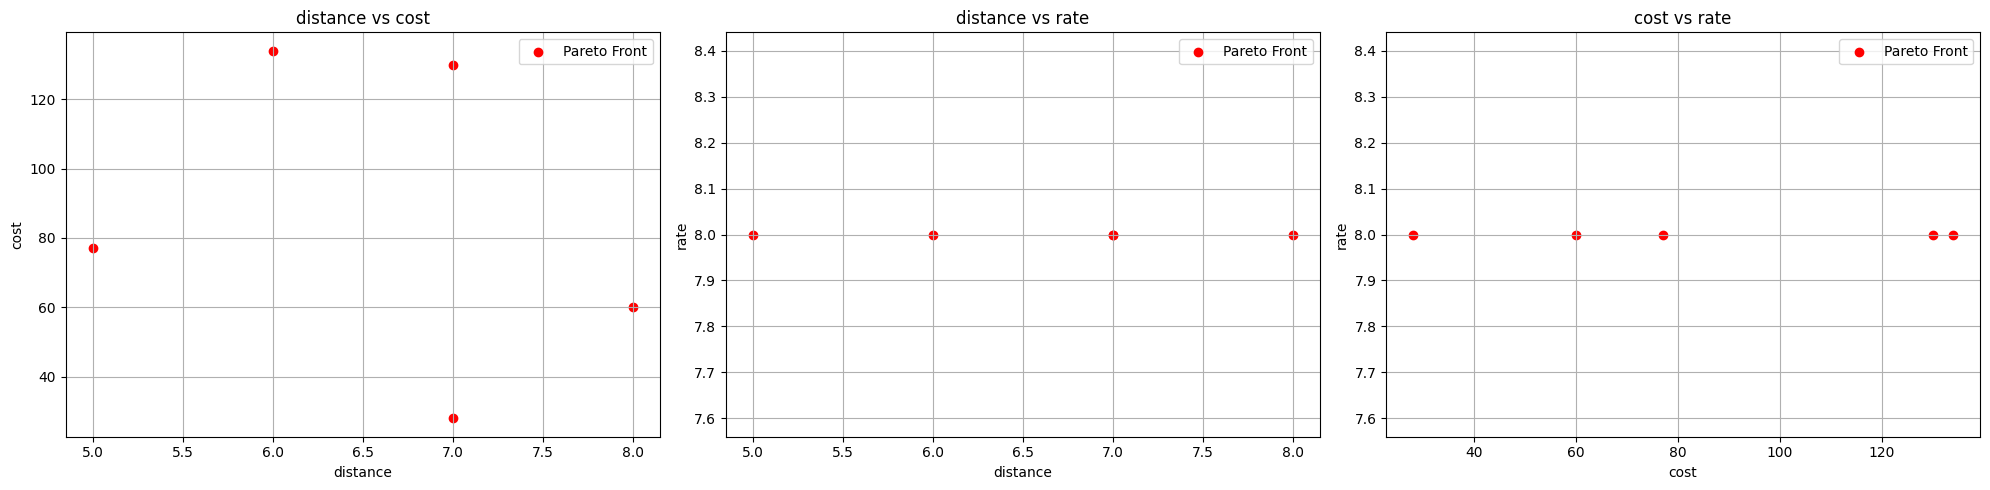

In [31]:
pareto_indices = NonDominatedSorting().do(res.F, only_non_dominated_front=False)  # بدون محدودیت به جبهه اول
pareto_fronts = [res.F[indices] for indices in pareto_indices]

# ایجاد نمودار ۳D
fig = go.Figure()

# رسم تمامی جبهه‌ها با رنگ‌های مختلف
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']  # لیستی از رنگ‌ها برای هر جبهه

for i, front in enumerate(pareto_fronts):
    x = front[:, 0]
    y = front[:, 1]
    z = abs(front[:, 2])

    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=5, color=colors[i % len(colors)]),  # رنگ جبهه‌ها به صورت چرخشی
        name=f'Pareto Front {i+1}'
    ))

# افزودن عنوان و نمایش نمودار
fig.update_layout(
    title='3D Scatter Plot of All Pareto Fronts',
    autosize=True,
    scene=dict(
        xaxis_title='Objective 1',
        yaxis_title='Objective 2',
        zaxis_title='Objective 3'
    )
)
fig.show()




fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111, projection='3d')
# رسم نقاط
ax.scatter(res.F[:, 0], res.F[:, 1], abs(res.F[:, 2]), label="All Solutions", color="gray", alpha=0.3)
ax.scatter(res.F[:, 0], res.F[:, 1], abs(res.F[:, 2]), label="Pareto Front", color="red", edgecolor="black", s=60)
# ax.scatter(x, y, z, c=z, cmap='viridis', s=10)  # s اندازه نقاط است
# تنظیم زاویه دید
ax.view_init(elev=10, azim=45)  # elev زاویه ارتفاع و azim زاویه افقی است
# نمایش نمودار
ax.set_xlabel("Distance")
ax.set_ylabel("Cost")
ax.set_zlabel("Rae")
ax.set_title("3D Pareto Front Visualization")
ax.legend()
plt.show()


plt.figure(figsize=(20, 5))

# هدف 1 مقابل هدف 2
plt.subplot(1, 3, 1)
# plt.scatter(res.F[:, 0], res.F[:, 1], c="gray", label="All Solutions")
plt.scatter(res.X[:, 0], res.X[:, 1], c="red", label="Pareto Front")
plt.xlabel("distance")
plt.ylabel("cost")
plt.title("distance vs cost")
plt.legend()
plt.grid()

# هدف 1 مقابل هدف 3
plt.subplot(1, 3, 2)

plt.scatter(res.X[:, 0], abs(res.X[:, 2]), c="red", label="Pareto Front")
plt.xlabel("distance")
plt.ylabel("rate")
plt.title("distance vs rate")
plt.legend()
plt.grid()

# هدف 2 مقابل هدف 3
plt.subplot(1, 3, 3)
plt.scatter(res.X[:, 1], abs(res.X[:, 2]), c="red", label="Pareto Front")
plt.xlabel("cost")
plt.ylabel("rate")
plt.title("cost vs rate")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [32]:
pareto_indices = NonDominatedSorting().do(res.F, only_non_dominated_front=False)  # بدون محدودیت به جبهه اول
pareto_fronts = [res.F[indices] for indices in pareto_indices]
pareto_solution = [res.X[indices] for indices in pareto_indices]
for i, solution in enumerate(pareto_solution[0]):

  print(solution[0:solution[0]*2+5])
  print('-----------------------------')

getSingleObjective(pareto_solution[0], GeneticAlgorithmConfig.preference)


[   6  134    8  988    4 1162    3 1188    3  219    3  919    7 1261
    3  134    8]
-----------------------------
[   8   60    8  187    3 1228    1  554    2 1300    1 1052    2  209
    4 1245    7  575    5   60    8]
-----------------------------
[   7   28    8  351    7  887    1  183    4 1111    2  953    6 1103
    3 1330    2   28    8]
-----------------------------
[   5   77    8  923    7 1188    3  219    3  919    7 1261    3   77
    8]
-----------------------------
[   7  130    8  195    3 1004    5  380    5  173    1 1241    1 1280
    5  575    5  130    8]
-----------------------------


([6, 8, 7, 5, 7],
 [5.806805500073251,
  39.90248841989791,
  32.98960946604784,
  4.836070286281212,
  35.57408164545118],
 [234.0037556689956,
  297.84128344946737,
  264.7286182273161,
  243.28883300862213,
  260.38052509516376],
 [16.400556807648623,
  36.271630536457614,
  10.276852034283815,
  1.14519164653964,
  171.05037067824833])

[0, 2, 3, 6, 7, 8]
--------------------------
[1, 4, 5]
--------------------------


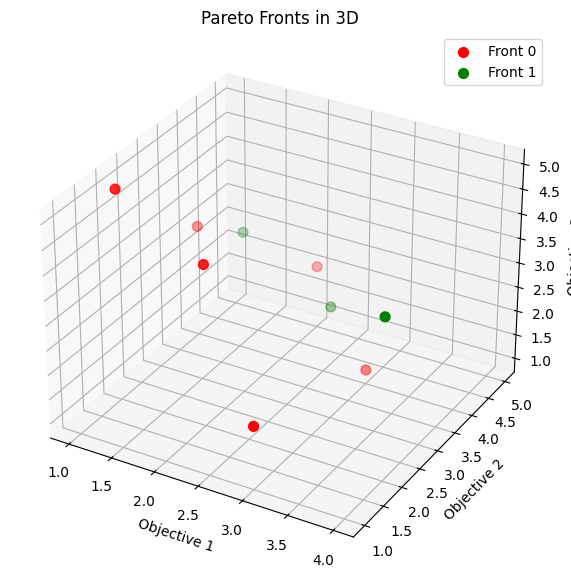

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def fast_non_dominated_sort(F):
    num_points = F.shape[0]
    S = [[] for _ in range(num_points)]
    front = [[]]
    n = [0] * num_points
    rank = [0] * num_points

    for p in range(num_points):
        for q in range(num_points):
            if p != q:  # حذف مقایسه خودش با خودش
                p_dominates_q = np.all(F[p] <= F[q]) and np.any(F[p] < F[q])
                q_dominates_p = np.all(F[q] <= F[p]) and np.any(F[q] < F[p])

                if p_dominates_q:
                    S[p].append(q)
                elif q_dominates_p:
                    n[p] += 1

        if n[p] == 0:
            rank[p] = 0
            front[0].append(p)

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        front.append(Q)
    del front[-1]

    return front

# 📌 ایجاد ماتریس F برای مسئله ۳ هدفه (مثال)
F = np.array([
    [1, 4, 3],
    [2, 3, 4],
    [2, 2, 4],
    [3, 1, 2],
    [3, 3, 3],
    [4, 2, 4],
    [1, 2, 5],
    [3, 4, 1],
    [2, 5, 2]
])

# 📌 محاسبه جبهه‌های پارتو
pareto_fronts = fast_non_dominated_sort(F)

# 📌 نمایش جبهه‌های پارتو در فضای ۳ بعدی
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i, front in enumerate(pareto_fronts):
    print(front)
    print('--------------------------')
    front_points = F[front]
    ax.scatter(front_points[:, 0], front_points[:, 1], front_points[:, 2],
               color=colors[i % len(colors)], label=f'Front {i}', s=50)

ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')
ax.set_title('Pareto Fronts in 3D')
ax.legend()
plt.show()


In [ ]:
locations[locations["Id"] == 121]

,Unnamed: 0,name,name:en,tag,type,Latitude,Longitude,Id,Stars,Price
121,121,بوتیک هتل روزبهان,Ruzbehan Boutique Hotel,[],hotel,52.550078,29.606732,121,3.591297,87.0


In [22]:
import folium

# ایجاد یک نقشه در مرکز اولین مکان
map_center = [locations["Longitude"].mean(), locations["Latitude"].mean()]
mymap = folium.Map(location=map_center, zoom_start=13)

index = 0
pareto_solutions = res.X
startRoute = GeneticAlgorithmConfig.totalLocationSize
endRoute  = (pareto_solutions[0][index][0] * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * 2)
for j in range(startRoute,
                endRoute,
                GeneticAlgorithmConfig.timePlaceMappingSize):
  node = locations[locations["Id"] == pareto_solutions[0][index][j]]
  color = 'blue'

  folium.Marker(
      location=[node["Longitude"].values[0], node["Latitude"].values[0]],
      popup=node["tag"].values[0],
      tooltip=f"{node['name'].values[0]}",
      icon=folium.Icon(color=color)
  ).add_to(mymap)


mymap




IndexError: invalid index to scalar variable.

In [23]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import numpy as np

# فرض کنید F ماتریس توابع هدف است (هر ردیف یک کروموزوم و هر ستون یک هدف)
F = np.array([
    [0.5, 0.5, 0.5],
    [0.2, 0.5, 0.5],
    [0.8, 0.2, 0.6],
    [0.6, 0.7, 0.9],
    [0.3, 0.9, 0.4],
    [0.4, 0.6, 0.2]
])

# اعمال مرتب‌سازی غیرمسلط
pareto_indices = NonDominatedSorting().do(F, only_non_dominated_front=False)

# تابع برای بررسی تسلط
def dominates(a, b):
    """بررسی اینکه آیا کروموزوم a بر کروموزوم b تسلط دارد یا خیر"""
    return np.all(a <= b) and np.any(a < b)

# نمایش جبهه‌های پارتو به همراه مقادیر توابع هدف و کروموزوم‌هایی که تسلط دارند
for i, pareto in enumerate(pareto_indices):
    print(f"Pareto Front {i+1}:")
    for idx in pareto:
        print(f"Index: {idx}, Objectives: {F[idx]}")
        # بررسی تسلط کروموزوم‌ها در داخل همان جبهه
        for other_idx in pareto:
            if other_idx != idx and dominates(F[idx], F[other_idx]):
                print(f"  Dominates: Index {other_idx}, Objectives: {F[other_idx]}")
    print('------------')

Pareto Front 1:
Index: 1, Objectives: [0.2 0.5 0.5]
Index: 2, Objectives: [0.8 0.2 0.6]
Index: 4, Objectives: [0.3 0.9 0.4]
Index: 5, Objectives: [0.4 0.6 0.2]
------------
Pareto Front 2:
Index: 0, Objectives: [0.5 0.5 0.5]
------------
Pareto Front 3:
Index: 3, Objectives: [0.6 0.7 0.9]
------------


الگوریتم فازی - برای هر هتل سه مقدار بدبینانه،خوش بینانه و متوسط رو در نظر می گیریم

In [ ]:
import requests

# API Key خود را اینجا وارد کنید
API_KEY = '3k_wLMNf6CwujHWVLSLnoZFLnuDLAkzBrLxfZU9GT5cG2tkgngTk3YcAD80AUOTE665dznOmk1LXWbVHFvtBehmk-ao0Dnzo7urxabgbhvXWcDzWSRNWfvoXm-cDZ3Yx'

# URL پایه برای درخواست‌ها
url = 'https://api.yelp.com/v3/businesses/SoSQhqqOaS10aUuxDr1YtA'

# سربرگ‌ها (Headers) با کلید API
headers = {
    'Authorization': f'Bearer {API_KEY}',
}

# پارامترهای جستجو (می‌توانید موقعیت جغرافیایی، نوع کسب‌وکار و غیره را مشخص کنید)
params = {
    # 'term': 'hotels',   # نوع کسب‌وکار
    'location': 'New York',  # مکان
    'limit': 5               # تعداد نتایج
}

# ارسال درخواست به Yelp API
response = requests.get(url, headers=headers, params=params)

# بررسی وضعیت درخواست و چاپ نتایج
if response.status_code == 200:
    data = response.json()
    businesses = data.get('businesses')
    print(businesses)
    # for business in businesses:
    #     print(f"Name: {business['name']}, Rating: {business['rating']}, Address: {', '.join(business['location']['display_address'])}")
else:
    print(f"Error: {response.status_code}, {response.text}")


In [ ]:
locations[locations['tag'].map(lambda tags: 'historic' in tags)]


,Unnamed: 0,name,name:en,tag,type,Latitude,Longitude,Id,Stars,Price
140,140,مسجد وکیل,Vakil Mosque,"['Religious', 'historic']",historic,52.545582,29.614005,140,1.982196,18.889752
141,141,ارگ کریم خان,Citadel of Karim Khan-e Zand,"['historic', 'Cultural', 'Photography']",historic,52.544577,29.618248,141,3.080254,29.237238
142,142,مدرسه خان,Madraseh-ye Khan College,['historic'],historic,52.546631,29.611752,142,2.315706,32.906583
143,143,مسجد نصیرالملک,Nasir al-Mulk Mosque,"['Religious', 'historic']",historic,52.548402,29.608794,143,2.548393,30.879055
146,146,مسجد حاج علی,Haj Ali Mosque,"['Religious', 'historic']",historic,52.547727,29.610769,146,2.843859,22.096141
147,147,سرای مشیر,Saraye Moshir,['historic'],historic,52.546141,29.613075,147,2.227785,18.146559
148,148,مسجد امامزاده سید تاج الدین,Imamzadeh Taj al-Din Gharib,"['Religious', 'historic']",historic,52.534332,29.609109,148,2.411113,22.341037
149,149,مسجد بغدادی,Baghdadi Mosque,"['Religious', 'historic']",historic,52.539049,29.606977,149,2.319237,17.494393
150,150,مسجد حاج باقر,Hach Baghir Mosque,"['Religious', 'historic']",historic,52.540465,29.607714,150,2.111328,31.061006
151,151,مسجد مشیر,Moshir Mosque,"['Religious', 'historic']",historic,52.537620,29.612097,151,2.801344,28.324791
